In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoConfig
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Dict, List
import argparse

In [3]:

def get_model_linear_layers(model: torch.nn.Module) -> Dict[str, torch.nn.Linear]:
    """Extract all linear layers from the model."""

    # We only want to see the MLP layers
    linear_layers = {}
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) and "mlp" in name: 
            linear_layers[name] = module
    return linear_layers

def visualize_linear_layer_weights(layer: torch.nn.Linear, layer_name: str):
    """Visualize the weights of a single linear layer."""
    weights = layer.weight.detach().cpu().numpy()
    
    plt.figure(figsize=(12, 8))
    
    # Heatmap of weights
    plt.subplot(2, 2, 1)
    plt.hexbin(
    x=np.arange(weights.shape[1]).repeat(weights.shape[0]),
    y=np.tile(np.arange(weights.shape[0]), weights.shape[1]),
    C=weights.flatten(),
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
    )
    plt.colorbar()
    plt.title(f'Weight Heatmap - {layer_name}')
    plt.xlabel('Output Features')
    plt.ylabel('Input Features')
    
    # Weight distribution histogram
    plt.subplot(2, 2, 2)
    plt.hist(weights.flatten(), bins=100, color='blue', alpha=0.7)
    plt.title(f'Weight Distribution - {layer_name}')
    plt.xlabel('Weight Value')
    plt.ylabel('Count')
    
    # Singular values (importance of different dimensions)
    # And also the show how many independent columns we have from the column space (0 singular value means dependent column)
    plt.subplot(2, 2, 3)
    u, s, vh = np.linalg.svd(weights.astype(np.float32), full_matrices=False)
    plt.plot(s, 'o-')
    plt.title(f'Singular Values - {layer_name}')
    plt.xlabel('Component')
    plt.ylabel('Singular Value')
    
    plt.tight_layout()
    plt.show()

def visualize_linear_layer_bias(layer: torch.nn.Linear, layer_name: str):
    """Visualize the bias of a single linear layer."""
    if layer.bias is not None:
        bias = layer.bias.detach().cpu().numpy()
        
        plt.figure(figsize=(10, 5))
        
        # Bias values
        plt.subplot(1, 2, 1)
        plt.bar(range(len(bias)), bias)
        plt.title(f'Bias Values - {layer_name}')
        plt.xlabel('Output Feature Index')
        plt.ylabel('Bias Value')
        
        # Bias distribution
        plt.subplot(1, 2, 2)
        plt.hist(bias, bins=50, color='green', alpha=0.7)
        plt.title(f'Bias Distribution - {layer_name}')
        plt.xlabel('Bias Value')
        plt.ylabel('Count')
        
        plt.tight_layout()
        plt.show()

def summarize_linear_layers(linear_layers: Dict[str, torch.nn.Linear]):
    """Print summary information about all linear layers."""
    print("\nLinear Layer Summary:")
    print("{:<60} {:<15} {:<15} {:<10}".format(
        "Layer Name", "Input Features", "Output Features", "Has Bias"))
    print("-" * 100)
    
    for name, layer in linear_layers.items():
        print("{:<60} {:<15} {:<15} {:<10}".format(
            name, 
            str(layer.in_features), 
            str(layer.out_features), 
            str(layer.bias is not None)))

def visualize_qwen_linear_layers(model_name: str = "Qwen/Qwen-7B", 
                                visualize_weights: bool = True,
                                visualize_bias: bool = False,
                                max_layers_to_plot: int = 5):
    """Main function to load Qwen model and visualize its linear layers."""
    try:
        # Load model config and model
        print(f"Loading model {model_name}...")
        config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(
            model_name, 
            config=config, 
            trust_remote_code=True,
            torch_dtype=torch.float16  # Use float16 to save memory
        )
        model.eval()
        print("Model loaded successfully.")
        
        # Get all linear layers
        linear_layers = get_model_linear_layers(model)
        print(f"Found {len(linear_layers)} linear layers in the model.")
        
        # Print summary
        summarize_linear_layers(linear_layers)
        
        # Visualize selected layers
        plotted_layers = 0
        for name, layer in linear_layers.items():
            if plotted_layers >= max_layers_to_plot:
                break
                
            print(f"\nVisualizing layer: {name}")
            print(f"Shape: {layer.weight.shape}")
            
            if visualize_weights:
                visualize_linear_layer_weights(layer, name)
            
            if visualize_bias and layer.bias is not None:
                visualize_linear_layer_bias(layer, name)
            
            plotted_layers += 1
            
    except Exception as e:
        print(f"Error: {e}")


Qwen3-0.6B-Base has the following features:

- Type: Causal Language Models
- Training Stage: Pretraining
- Number of Parameters: 0.6B
- Number of Paramaters (Non-Embedding): 0.44B
- Number of Layers: 28
- Number of Attention Heads (GQA): 16 for Q and 8 for KV
- Context Length: 32,768


## Architecture of the MLP layers
 1. Projection Layer Roles

| Layer       | Shape (Input→Output) | Purpose                                                                 | Activation       |
|-------------|-----------------------|-------------------------------------------------------------------------|------------------|
| `gate_proj` | $1024 \rightarrow 3072$ | Learns "gating" values to control information flow                      | $\text{SiLU}$ (Swish) |
| `up_proj`   | $1024 \rightarrow 3072$ | Learns primary feature expansions (like a standard FFN)                 | None (Linear)    |
| `down_proj` | $3072 \rightarrow 1024$ | Compresses mixed features back to original dimension                    | None (Linear)    |

 2. Mathematical Flow

The MLP computes:

$$
\text{Output} = \text{down\_proj}\Big(\text{SiLU}\big(\text{gate\_proj}(x)\big) \odot \text{up\_proj}(x)\Big)
$$

Where:
- $\odot$ = element-wise multiplication (Hadamard product)
- $\text{SiLU}(x) = x \cdot \sigma(x)$ (Sigmoid-weighted Linear Unit)

Loading model Qwen/Qwen3-0.6B-Base...
Model loaded successfully.
Found 84 linear layers in the model.

Linear Layer Summary:
Layer Name                                                   Input Features  Output Features Has Bias  
----------------------------------------------------------------------------------------------------
model.layers.0.mlp.gate_proj                                 1024            3072            False     
model.layers.0.mlp.up_proj                                   1024            3072            False     
model.layers.0.mlp.down_proj                                 3072            1024            False     
model.layers.1.mlp.gate_proj                                 1024            3072            False     
model.layers.1.mlp.up_proj                                   1024            3072            False     
model.layers.1.mlp.down_proj                                 3072            1024            False     
model.layers.2.mlp.gate_proj                  

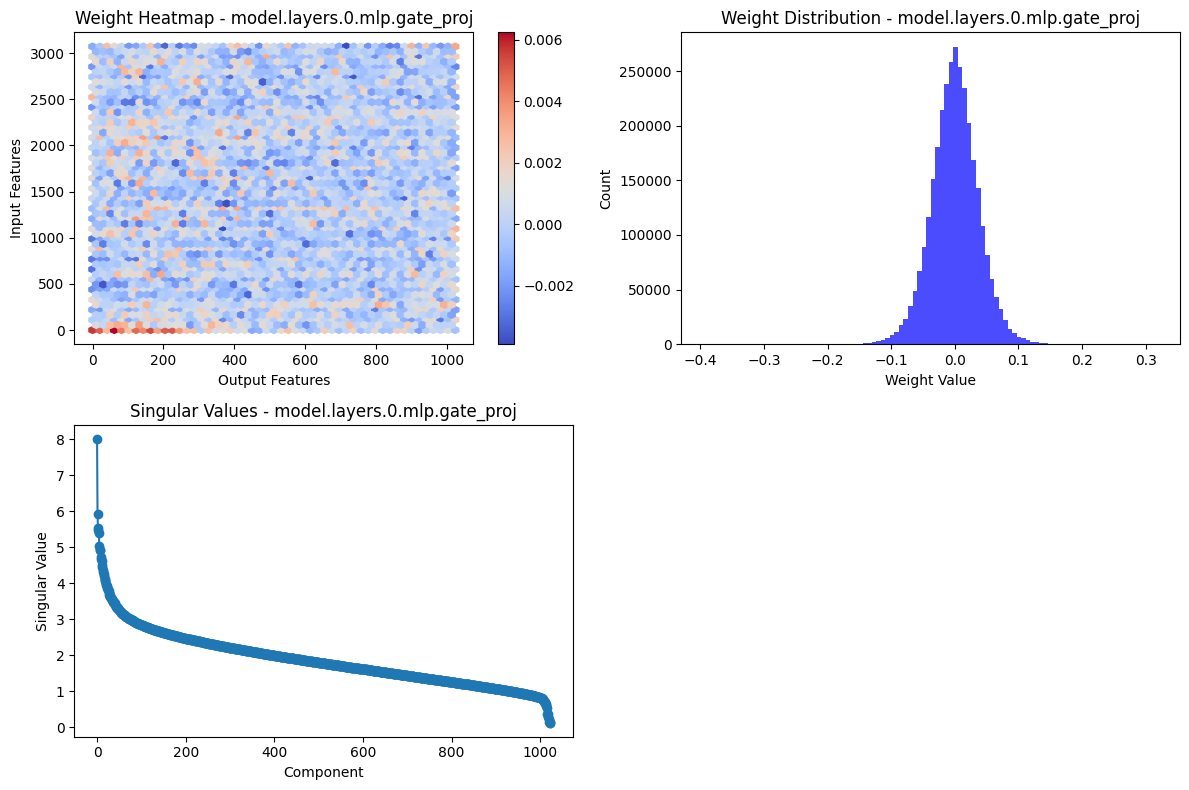


Visualizing layer: model.layers.0.mlp.up_proj
Shape: torch.Size([3072, 1024])


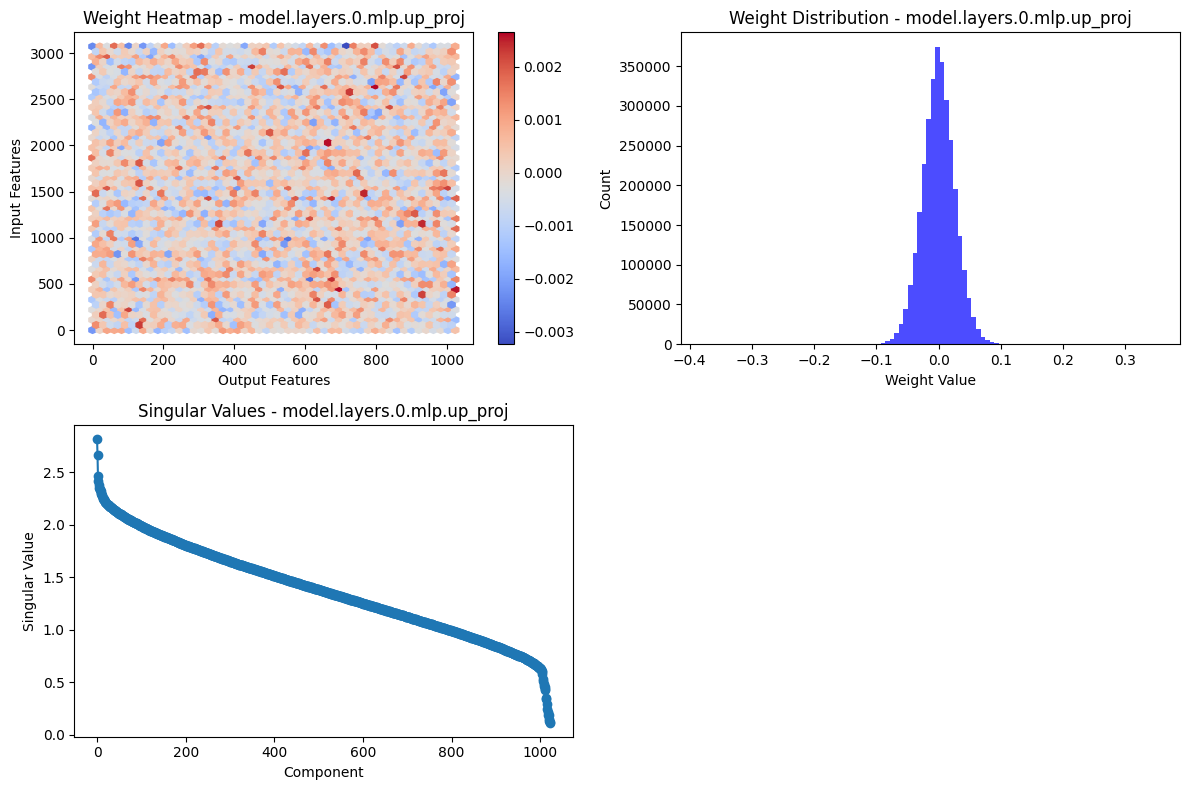


Visualizing layer: model.layers.0.mlp.down_proj
Shape: torch.Size([1024, 3072])


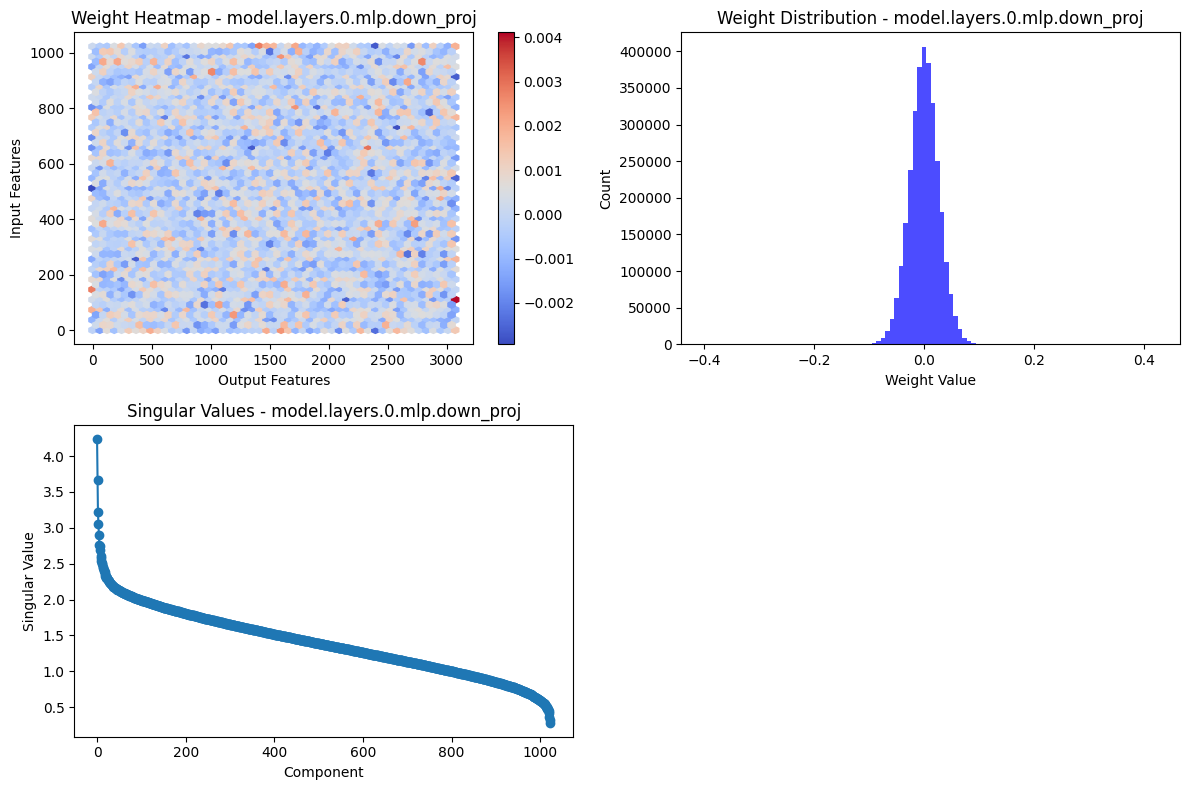


Visualizing layer: model.layers.1.mlp.gate_proj
Shape: torch.Size([3072, 1024])


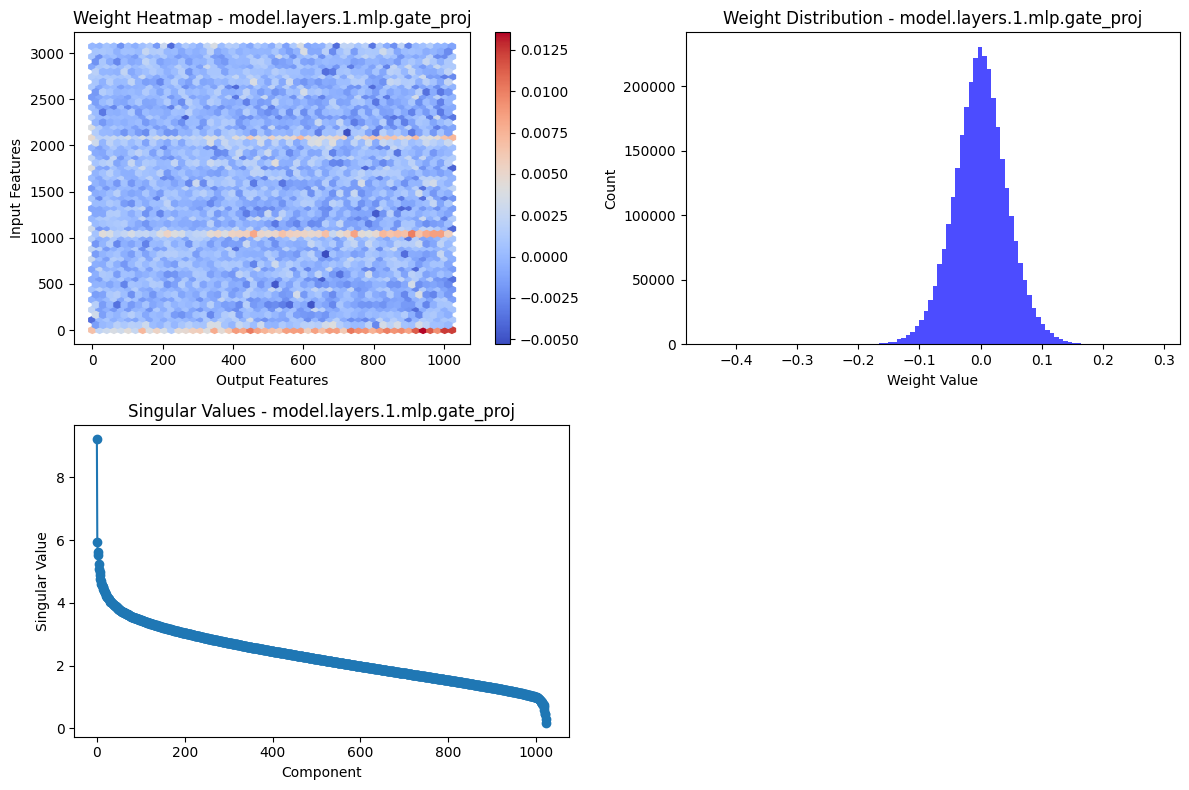


Visualizing layer: model.layers.1.mlp.up_proj
Shape: torch.Size([3072, 1024])


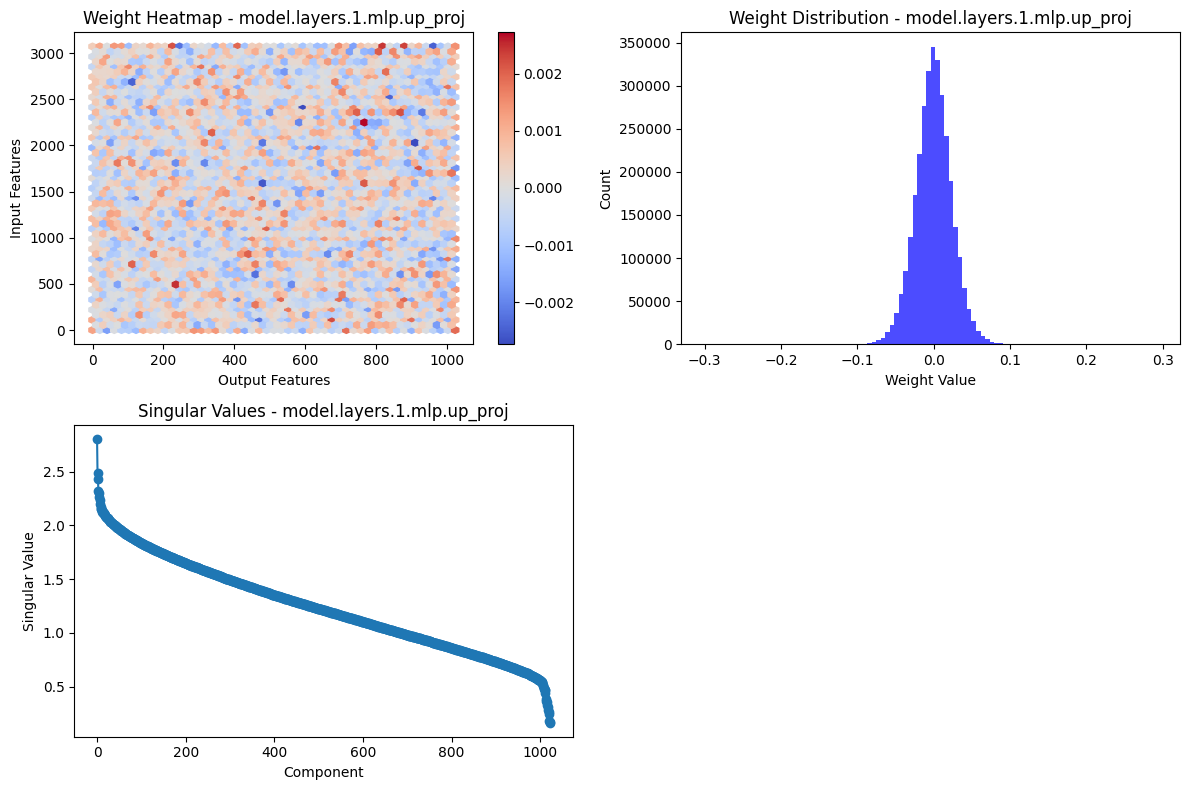


Visualizing layer: model.layers.1.mlp.down_proj
Shape: torch.Size([1024, 3072])



Visualizing layer: model.layers.2.mlp.gate_proj
Shape: torch.Size([3072, 1024])


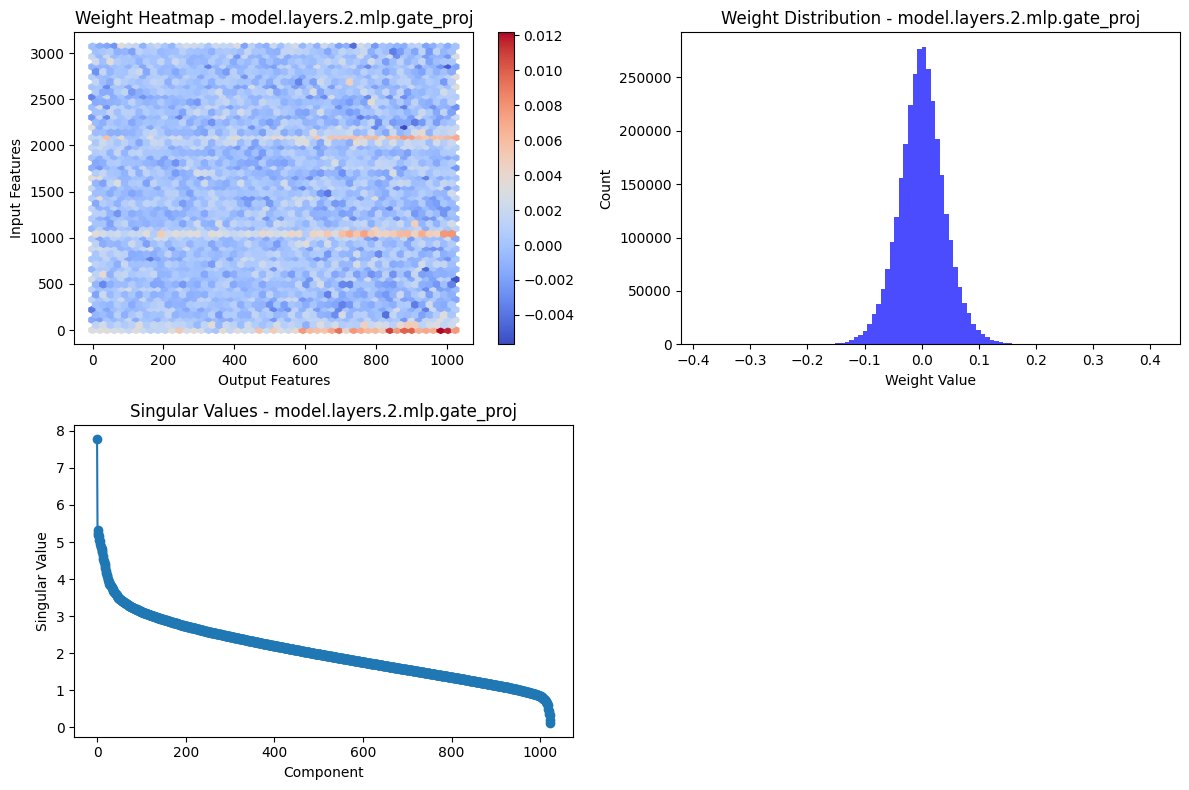


Visualizing layer: model.layers.2.mlp.up_proj
Shape: torch.Size([3072, 1024])


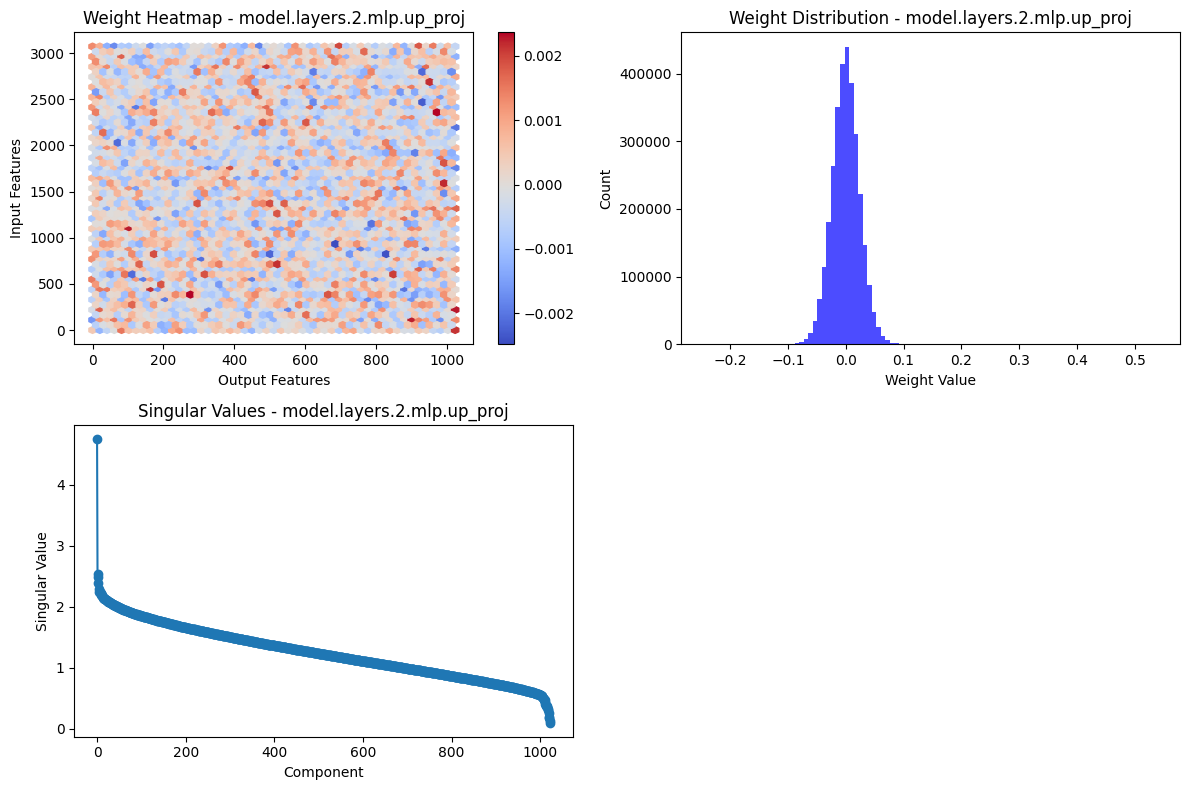


Visualizing layer: model.layers.2.mlp.down_proj
Shape: torch.Size([1024, 3072])


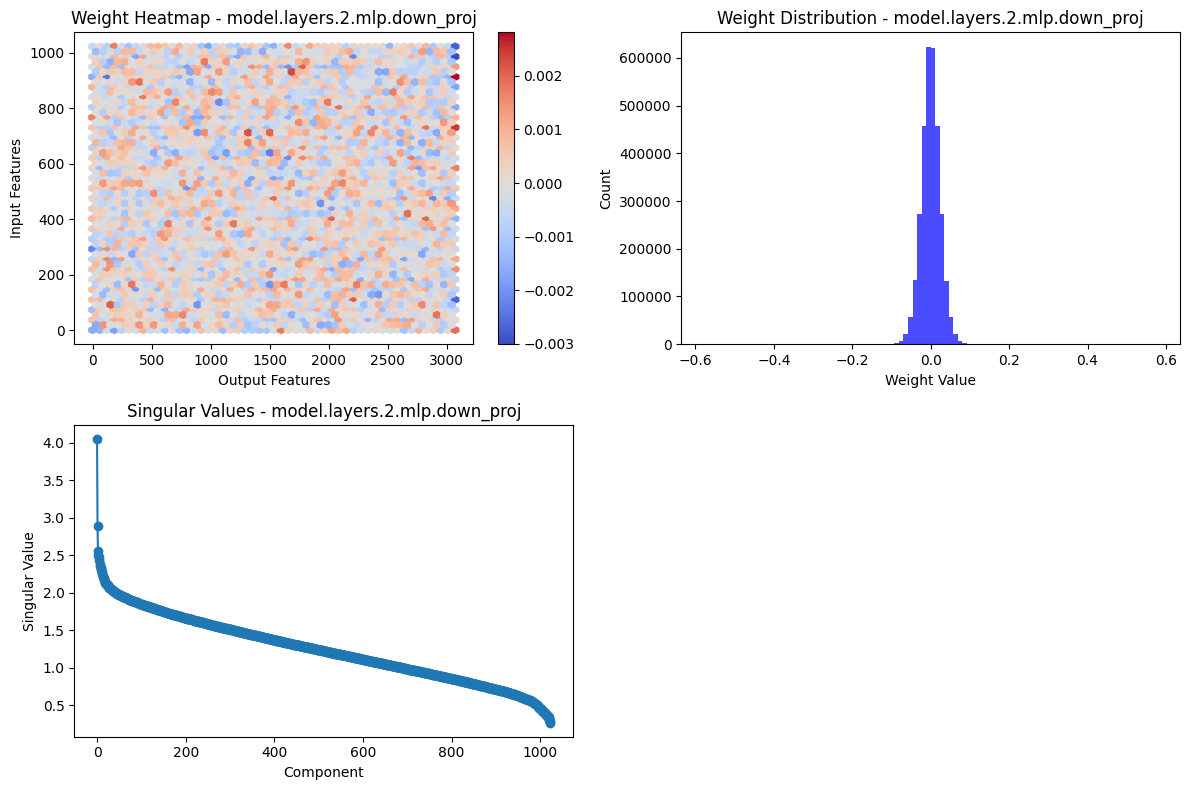


Visualizing layer: model.layers.3.mlp.gate_proj
Shape: torch.Size([3072, 1024])


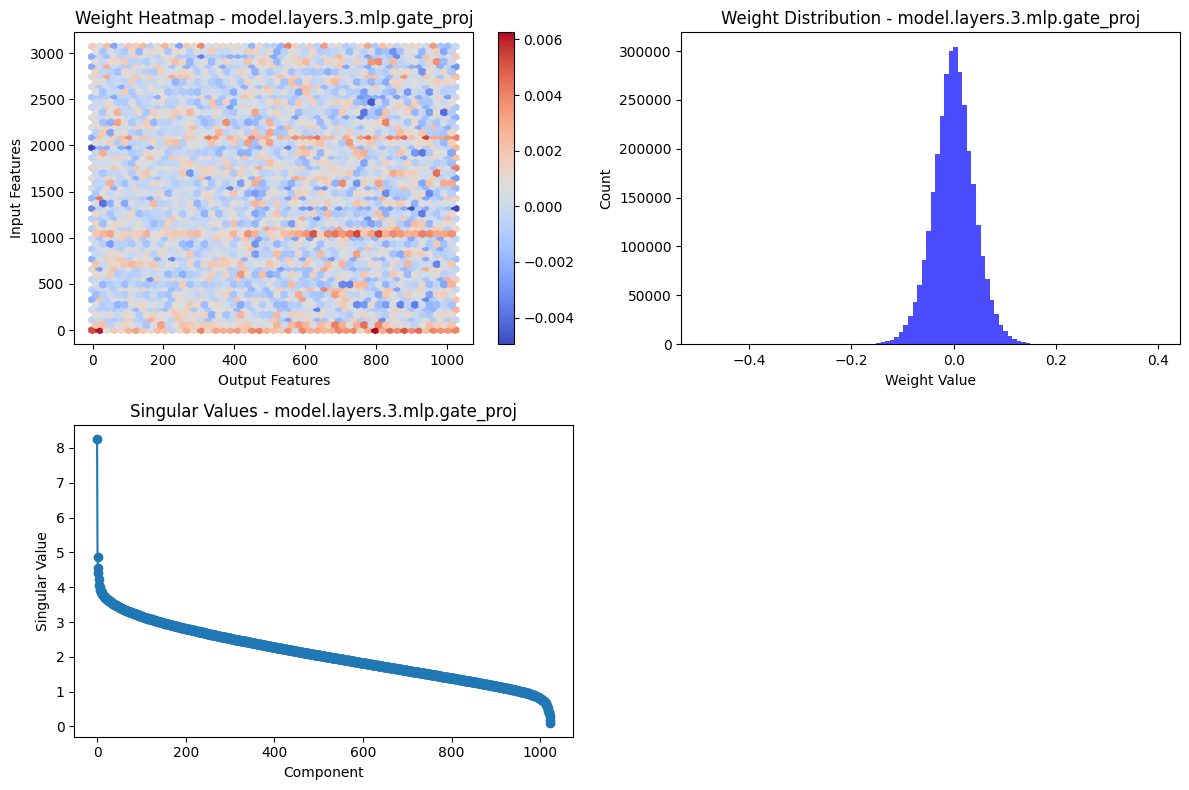


Visualizing layer: model.layers.3.mlp.up_proj
Shape: torch.Size([3072, 1024])


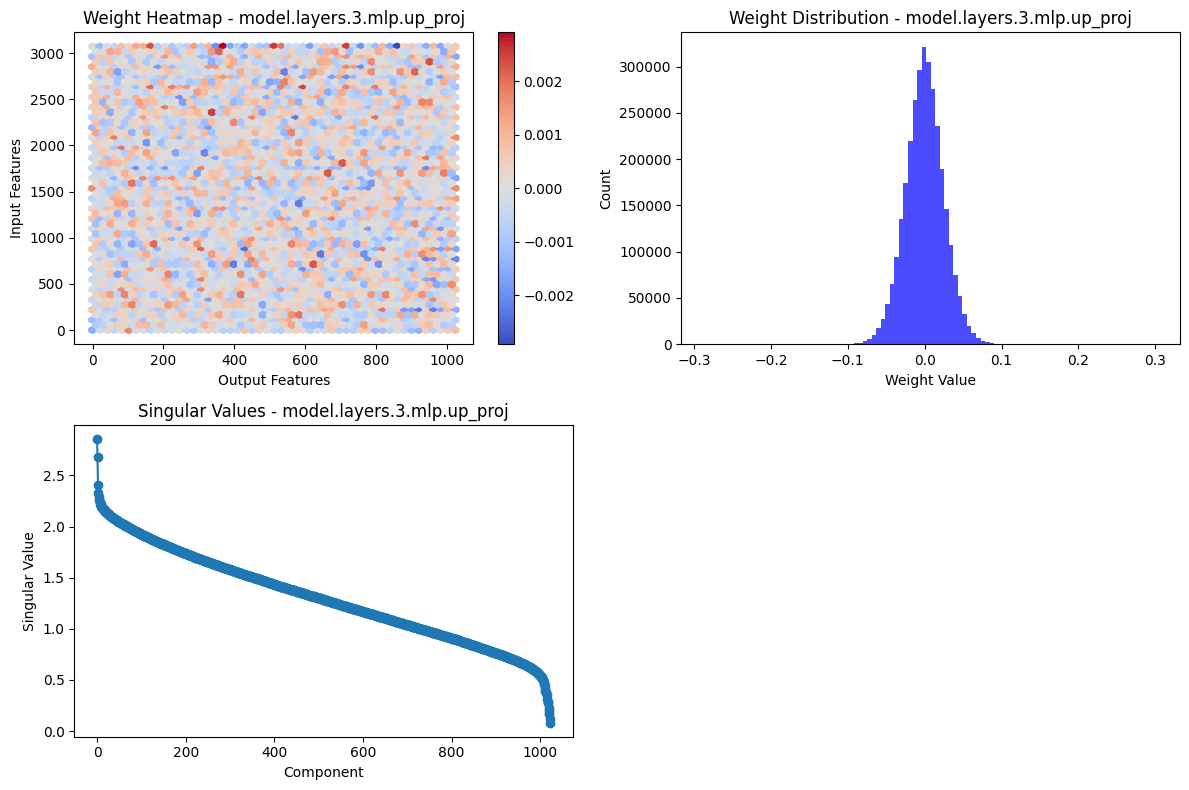


Visualizing layer: model.layers.3.mlp.down_proj
Shape: torch.Size([1024, 3072])


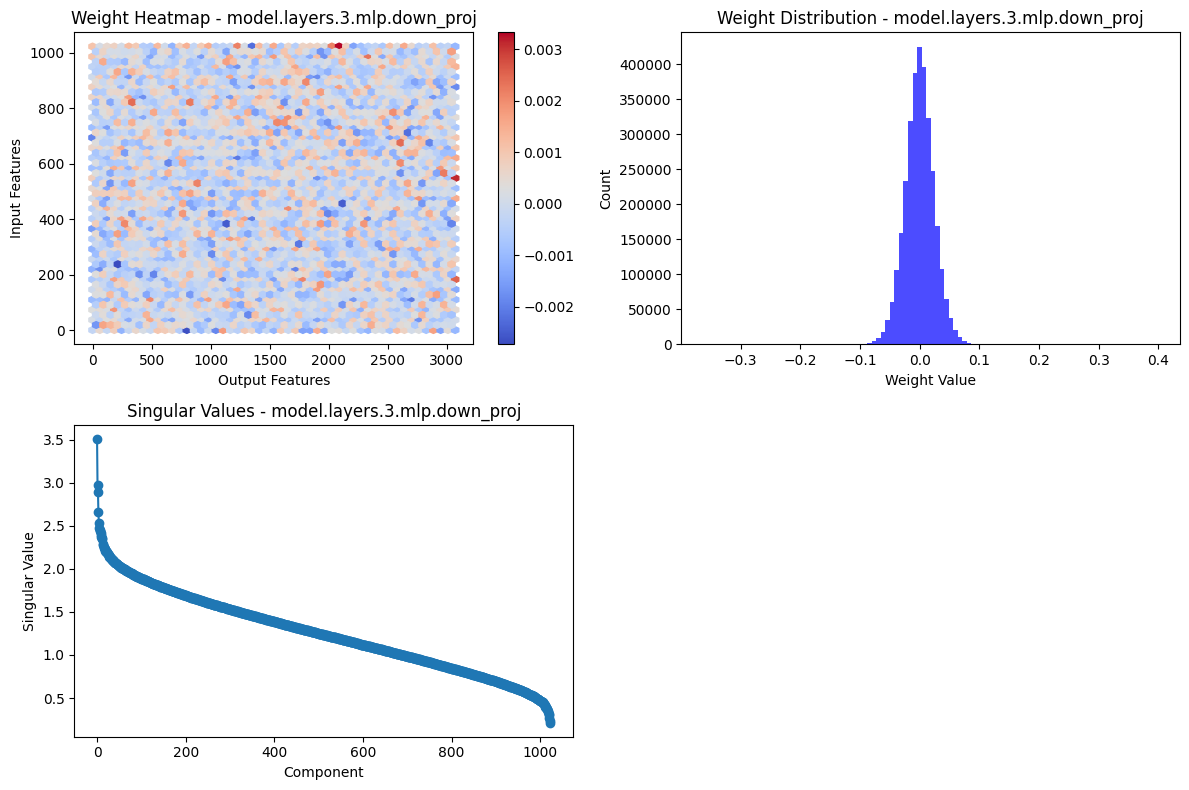


Visualizing layer: model.layers.4.mlp.gate_proj
Shape: torch.Size([3072, 1024])


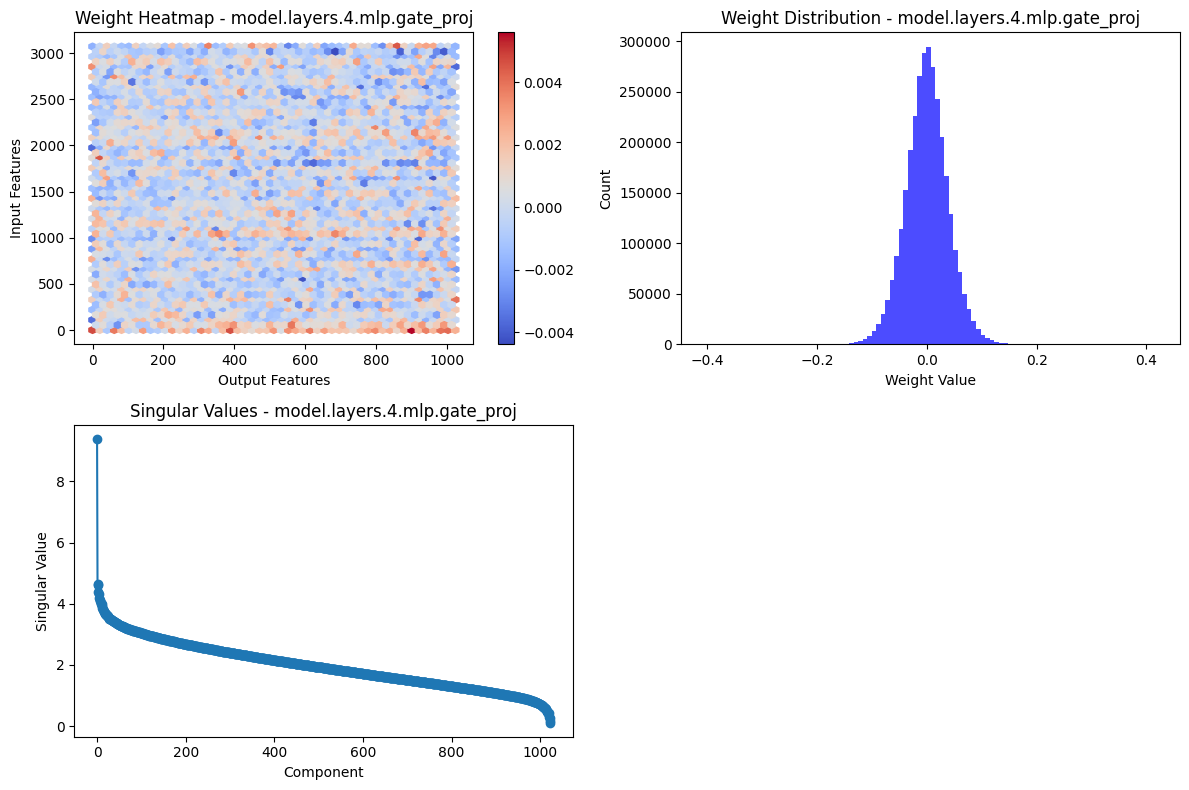


Visualizing layer: model.layers.4.mlp.up_proj
Shape: torch.Size([3072, 1024])


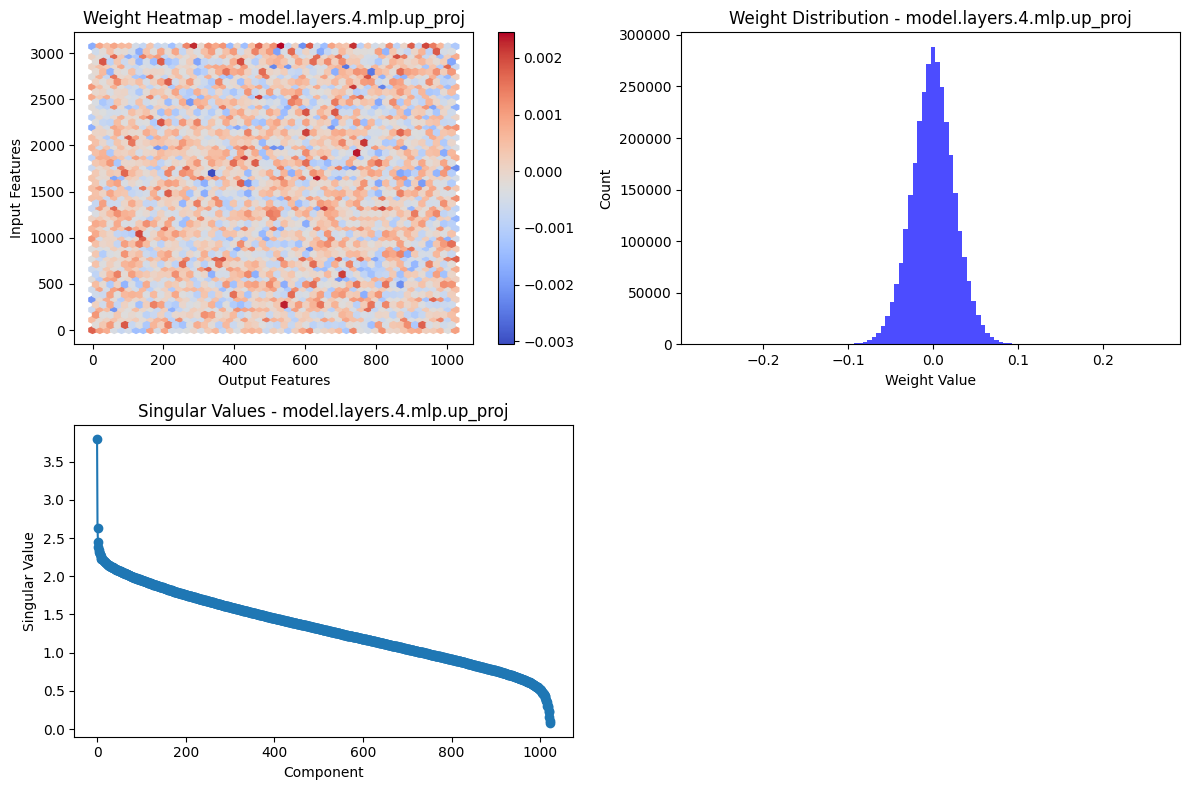


Visualizing layer: model.layers.4.mlp.down_proj
Shape: torch.Size([1024, 3072])


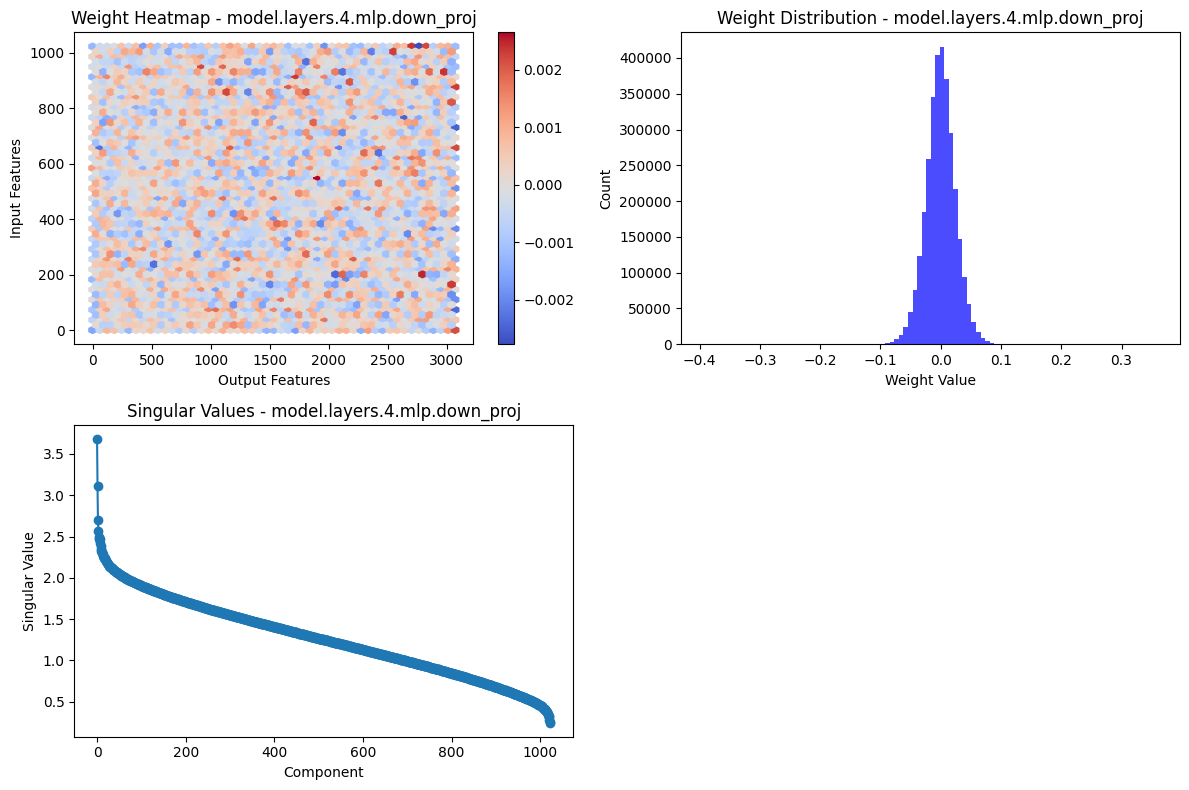


Visualizing layer: model.layers.5.mlp.gate_proj
Shape: torch.Size([3072, 1024])


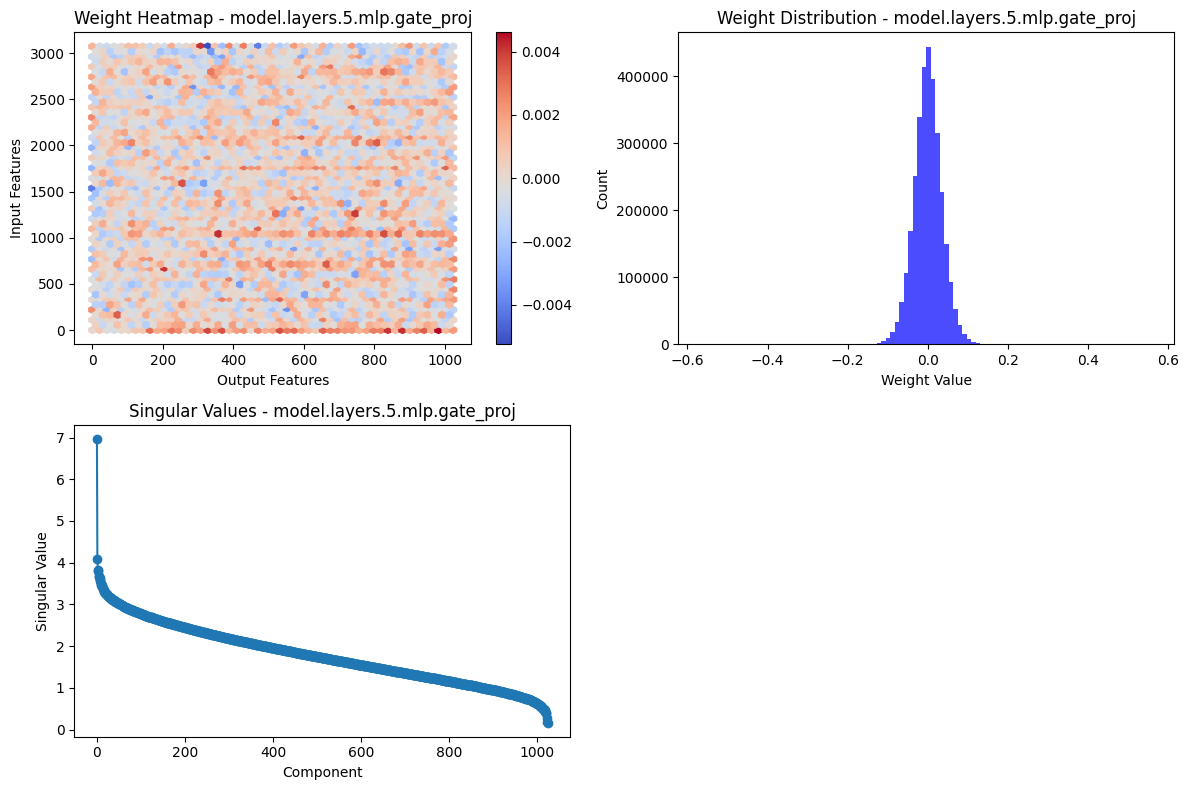


Visualizing layer: model.layers.5.mlp.up_proj
Shape: torch.Size([3072, 1024])


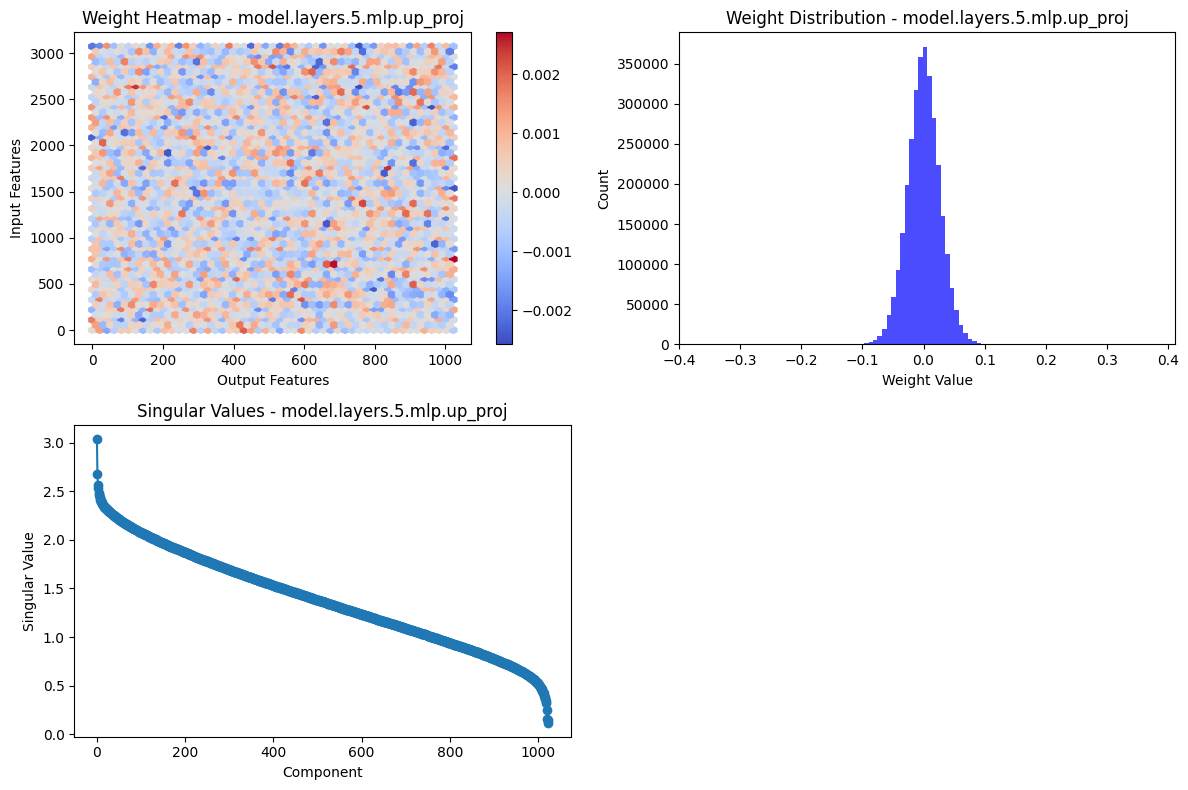


Visualizing layer: model.layers.5.mlp.down_proj
Shape: torch.Size([1024, 3072])


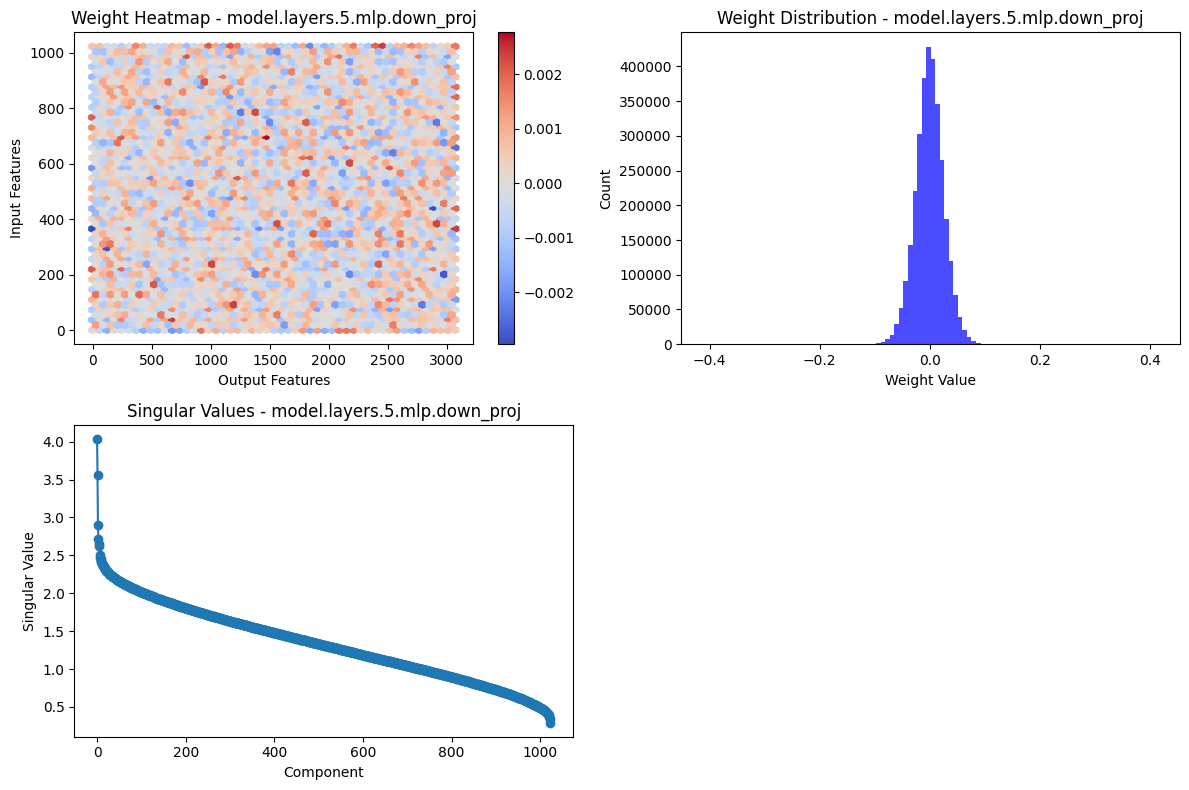


Visualizing layer: model.layers.6.mlp.gate_proj
Shape: torch.Size([3072, 1024])


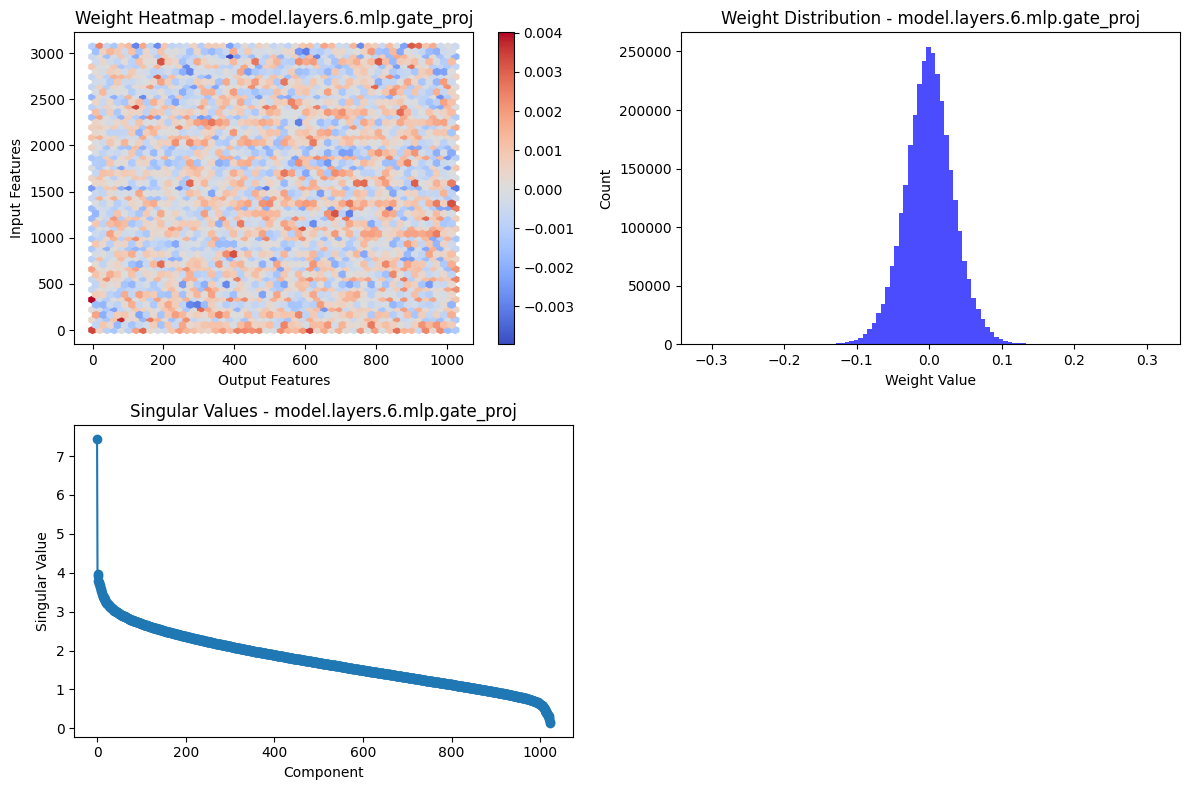


Visualizing layer: model.layers.6.mlp.up_proj
Shape: torch.Size([3072, 1024])


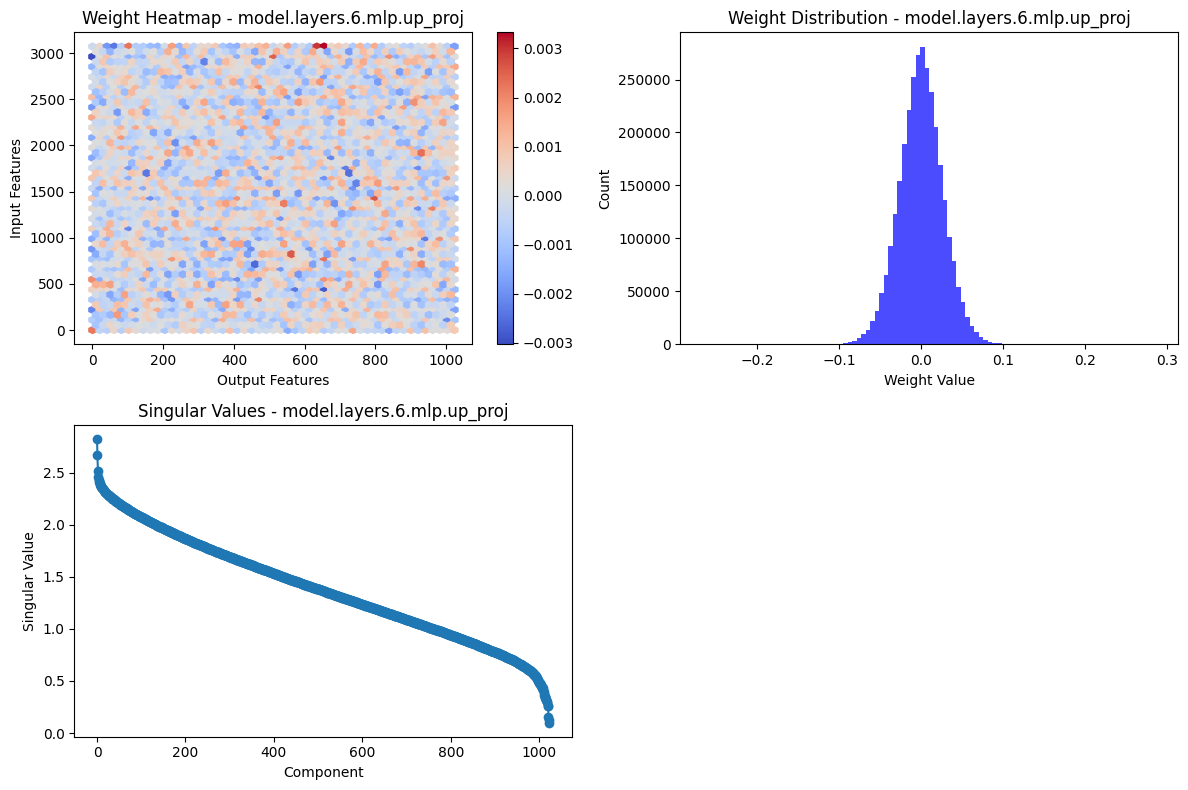


Visualizing layer: model.layers.6.mlp.down_proj
Shape: torch.Size([1024, 3072])


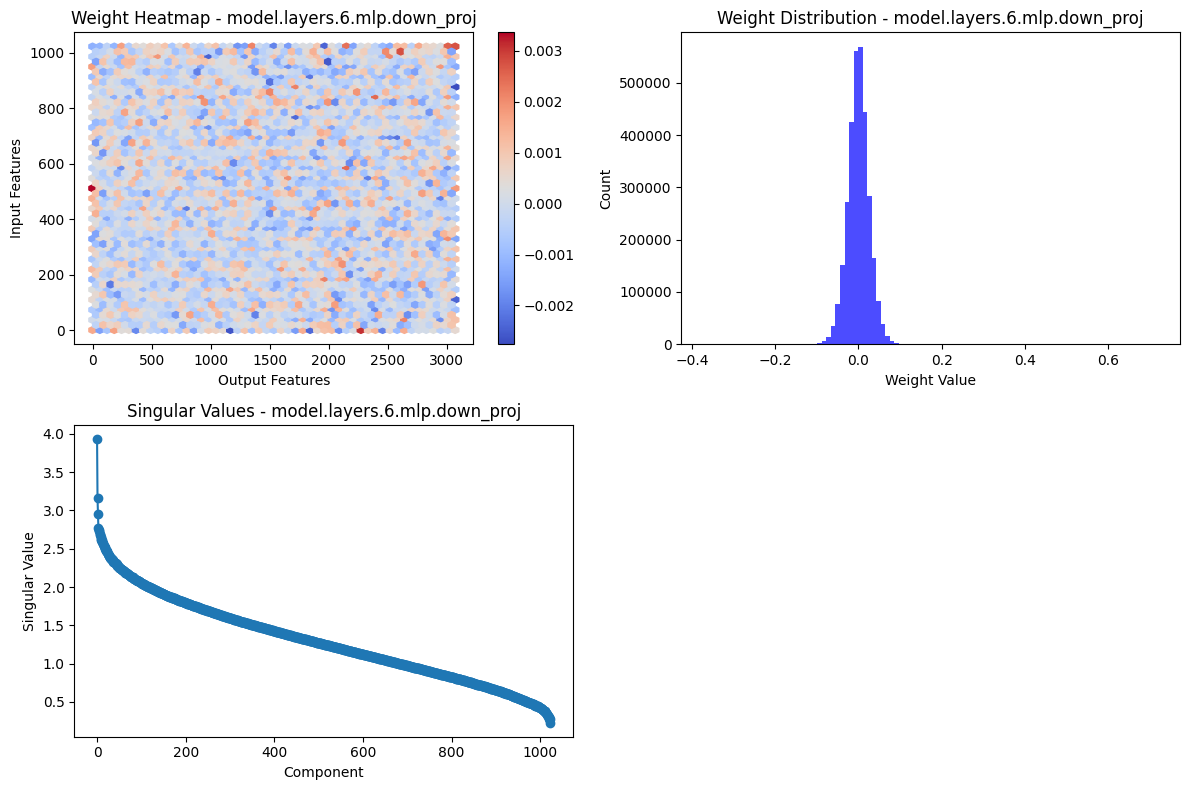


Visualizing layer: model.layers.7.mlp.gate_proj
Shape: torch.Size([3072, 1024])


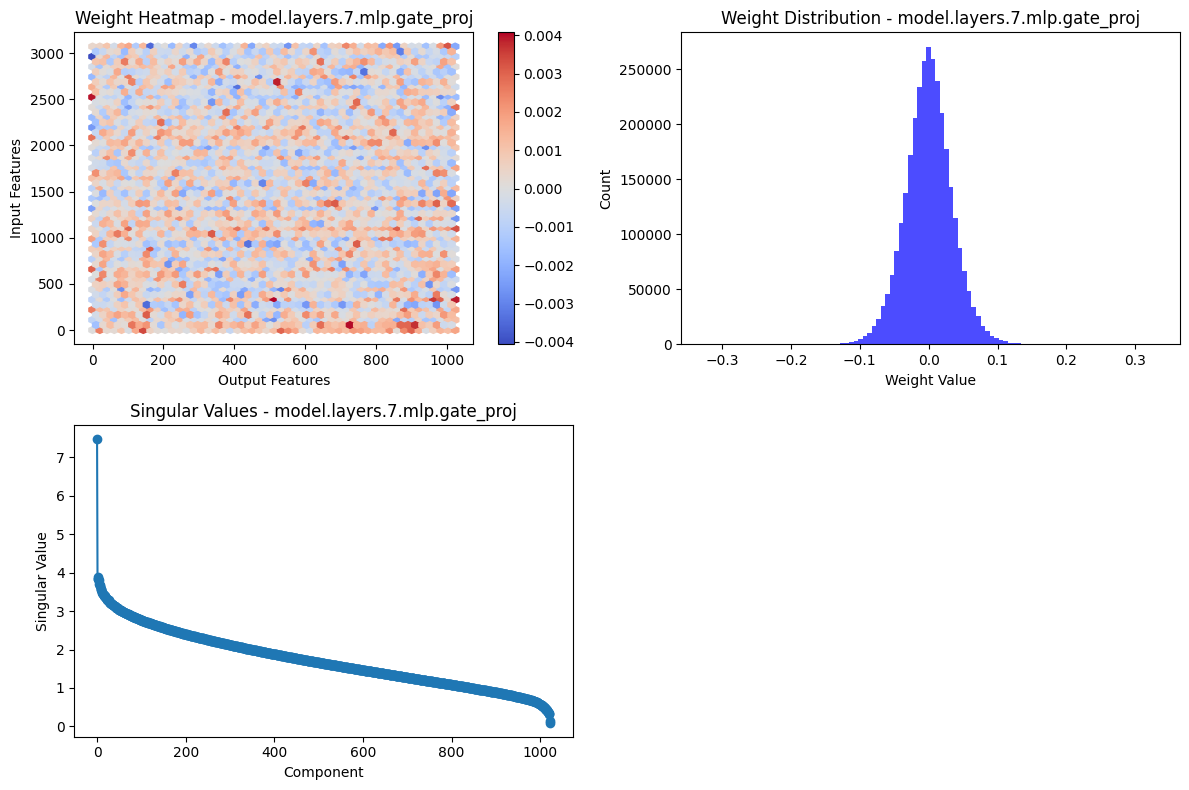


Visualizing layer: model.layers.7.mlp.up_proj
Shape: torch.Size([3072, 1024])


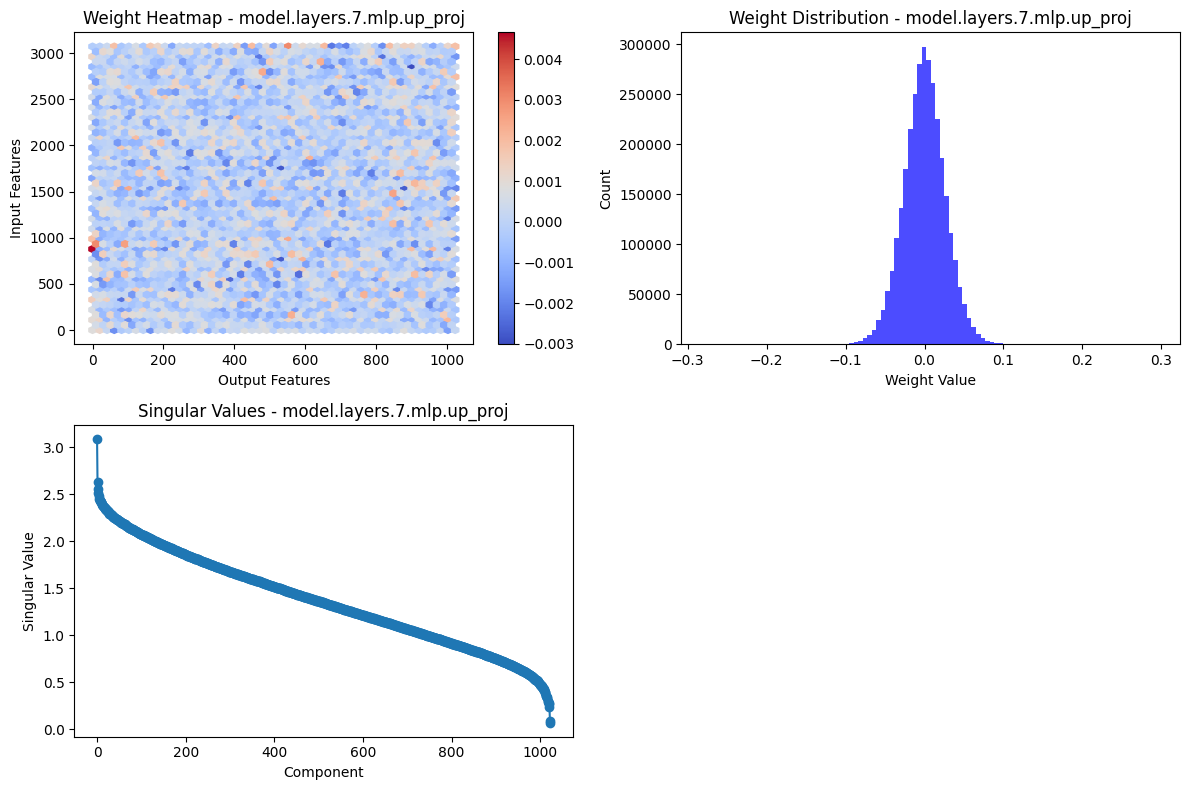


Visualizing layer: model.layers.7.mlp.down_proj
Shape: torch.Size([1024, 3072])


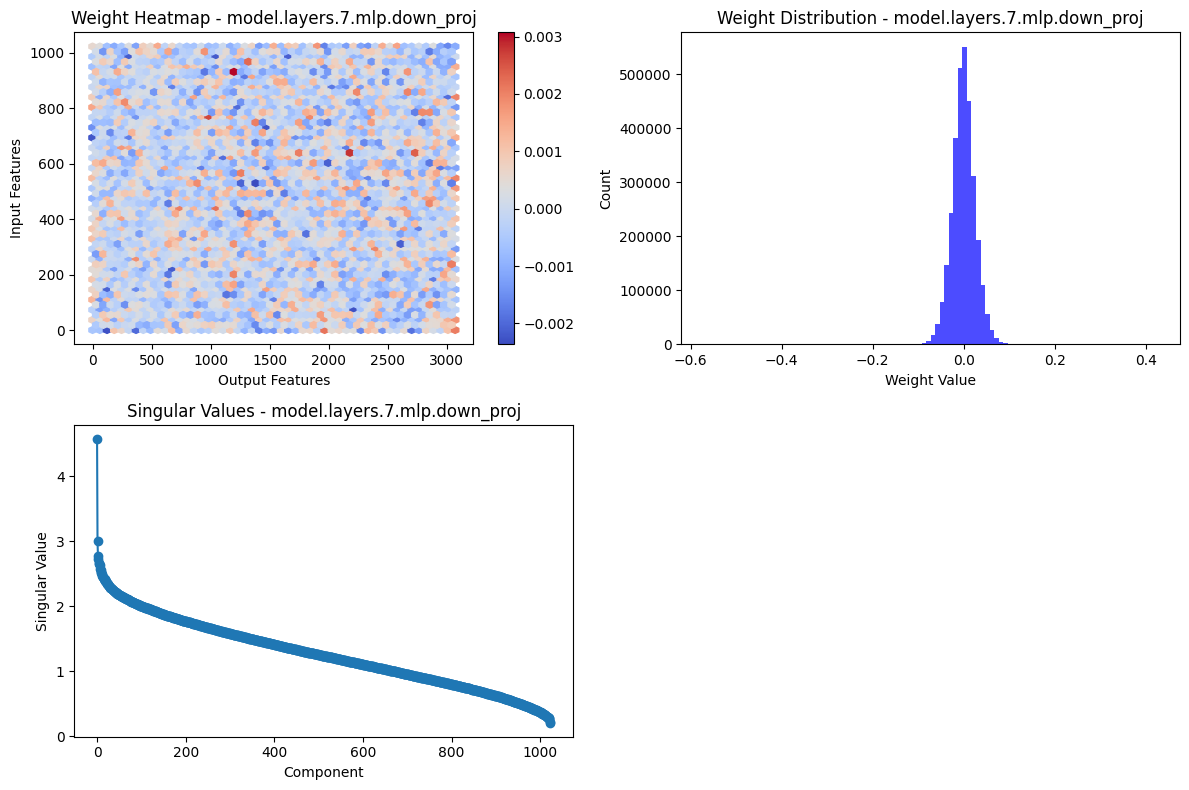


Visualizing layer: model.layers.8.mlp.gate_proj
Shape: torch.Size([3072, 1024])


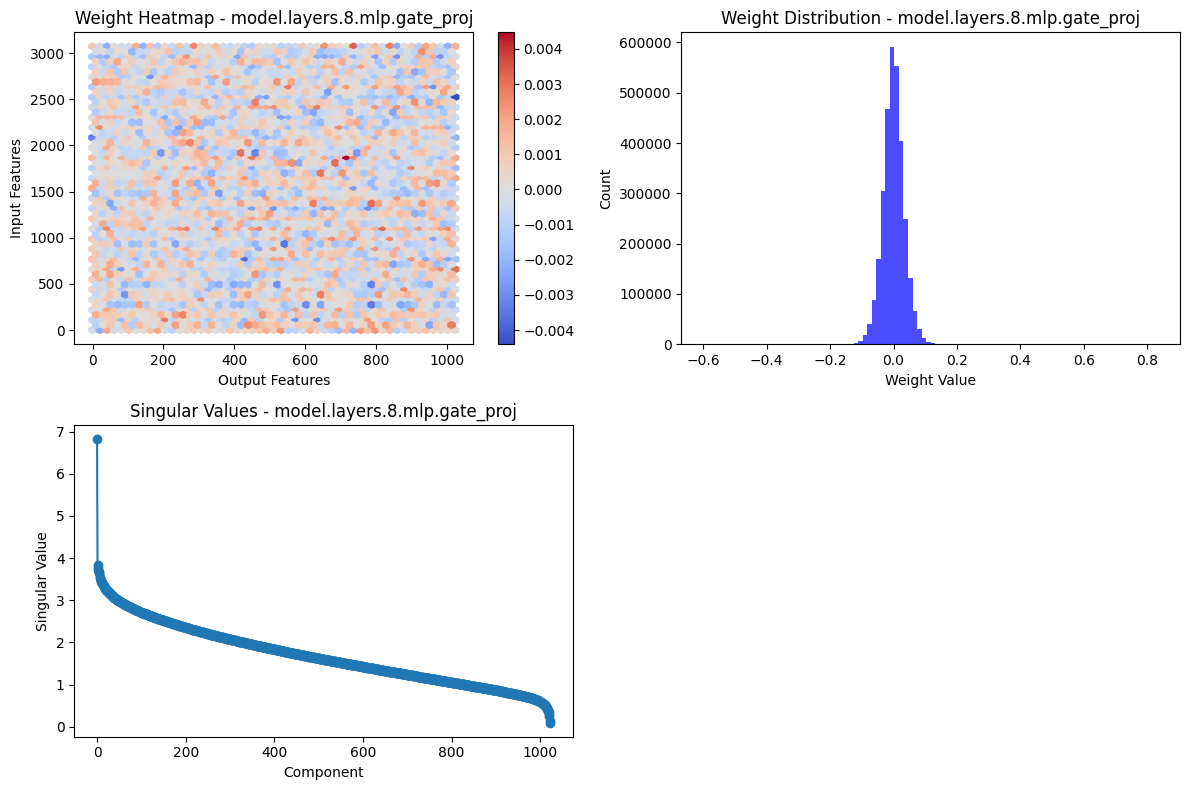


Visualizing layer: model.layers.8.mlp.up_proj
Shape: torch.Size([3072, 1024])


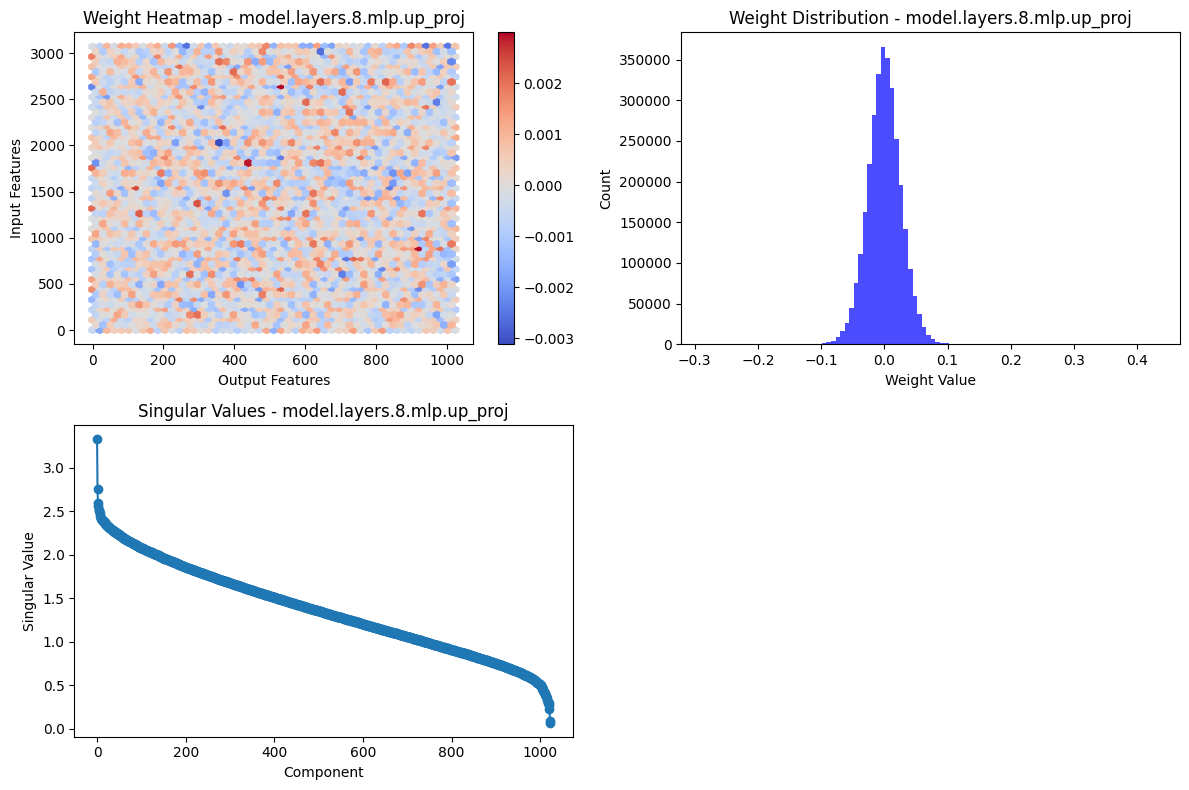


Visualizing layer: model.layers.8.mlp.down_proj
Shape: torch.Size([1024, 3072])


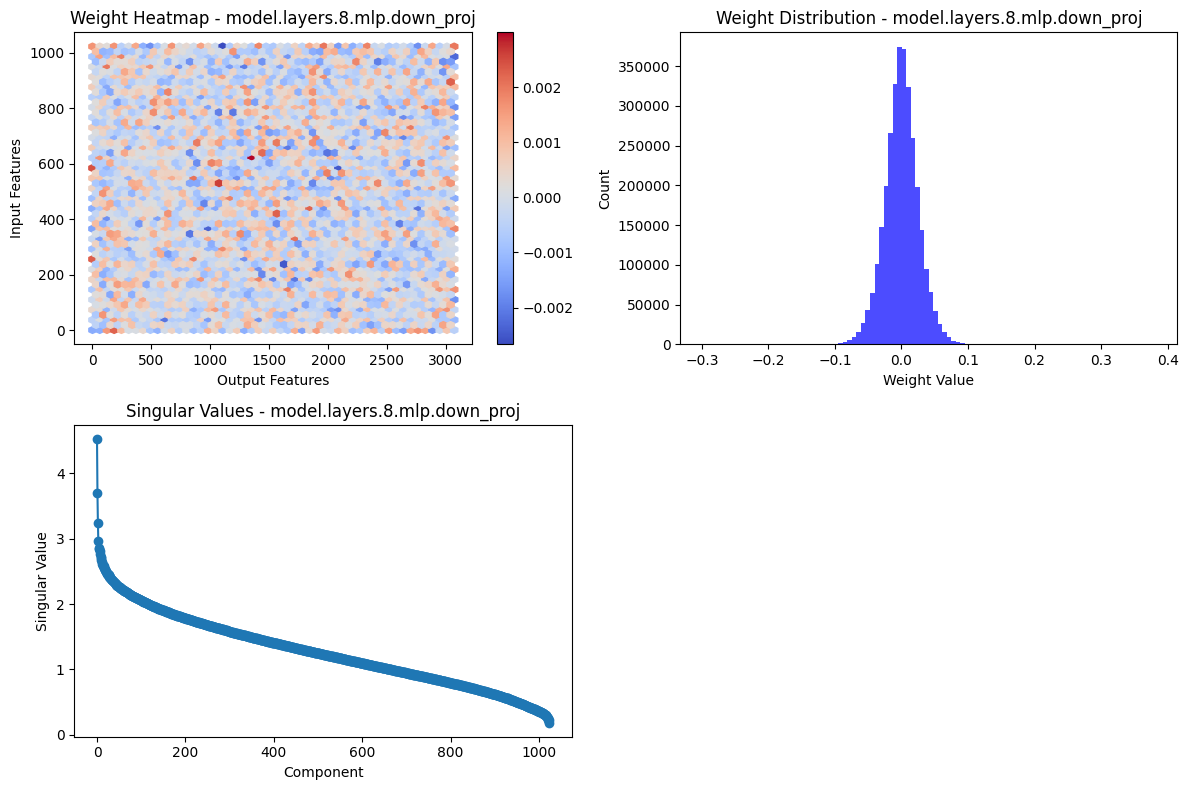


Visualizing layer: model.layers.9.mlp.gate_proj
Shape: torch.Size([3072, 1024])


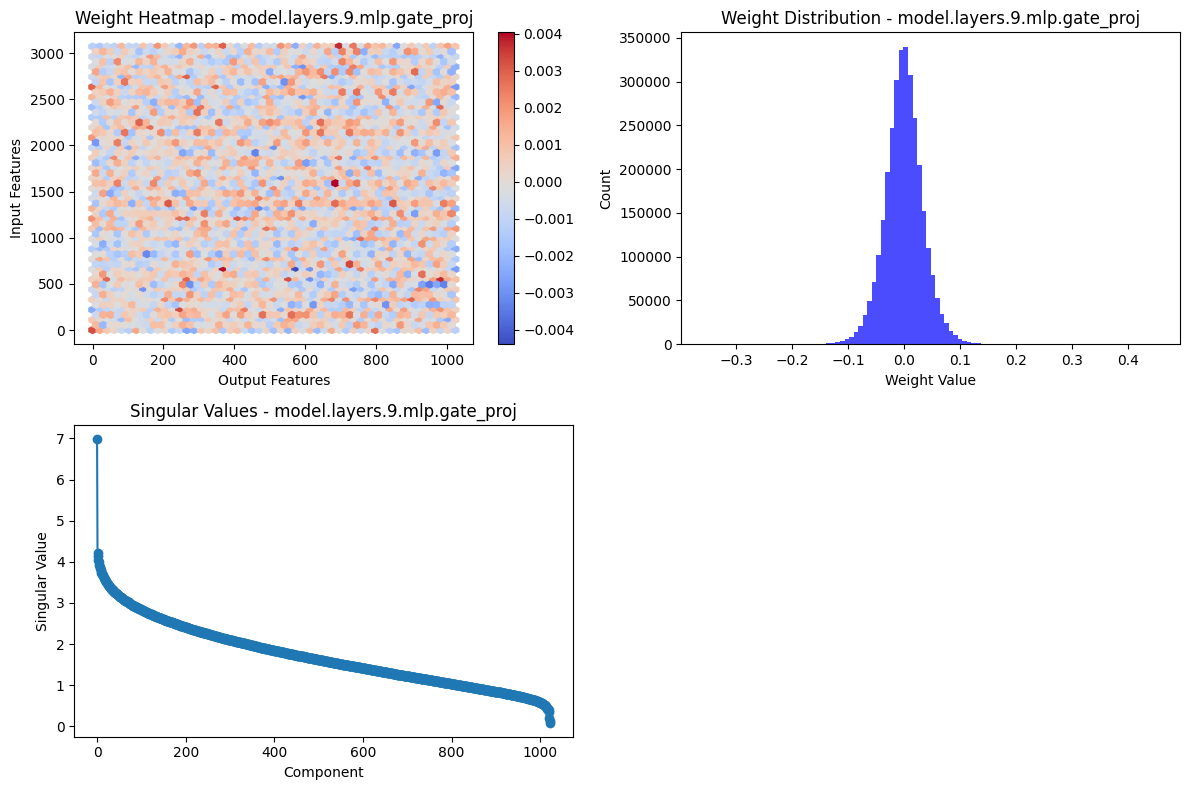


Visualizing layer: model.layers.9.mlp.up_proj
Shape: torch.Size([3072, 1024])


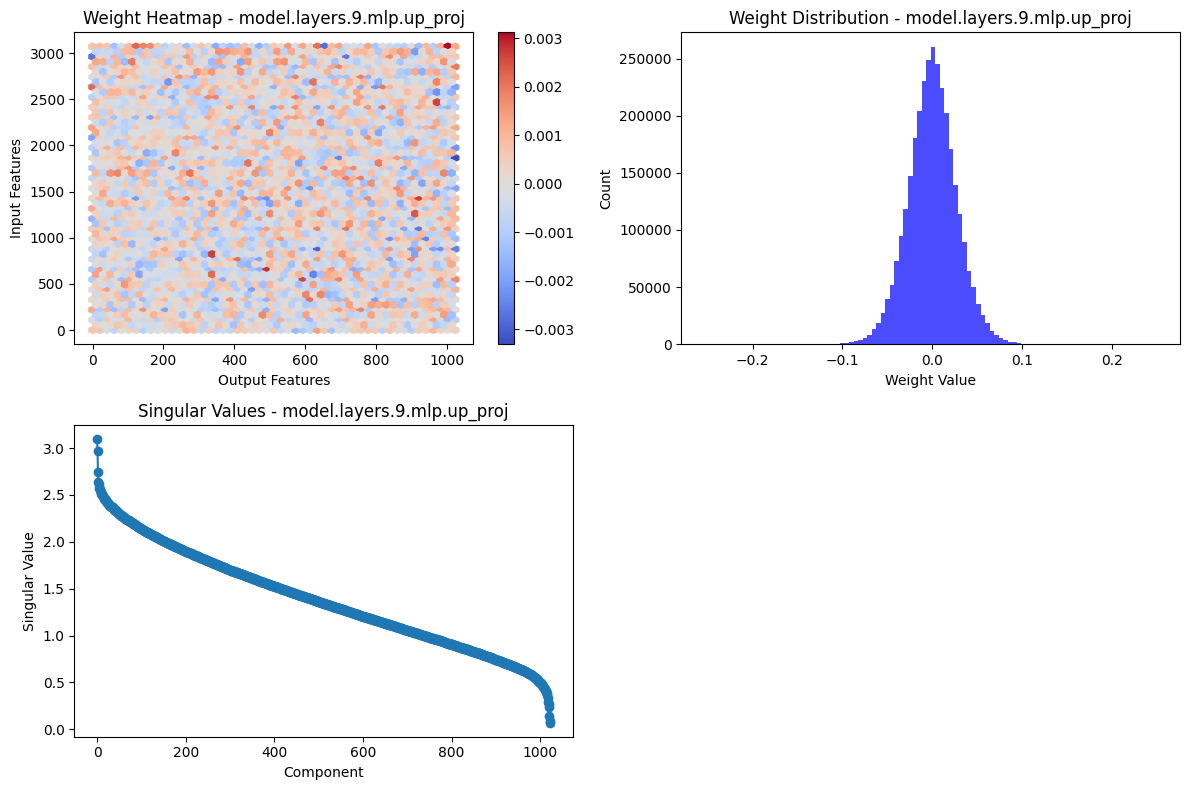


Visualizing layer: model.layers.9.mlp.down_proj
Shape: torch.Size([1024, 3072])


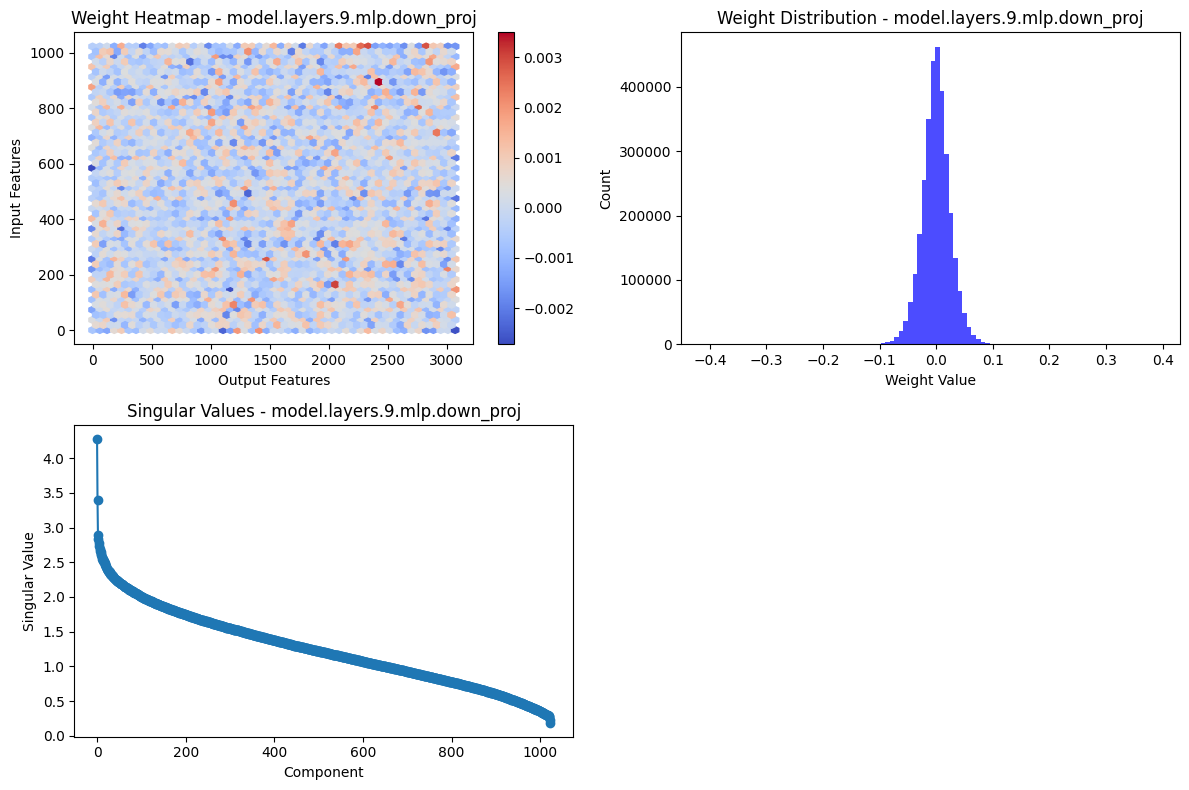


Visualizing layer: model.layers.10.mlp.gate_proj
Shape: torch.Size([3072, 1024])


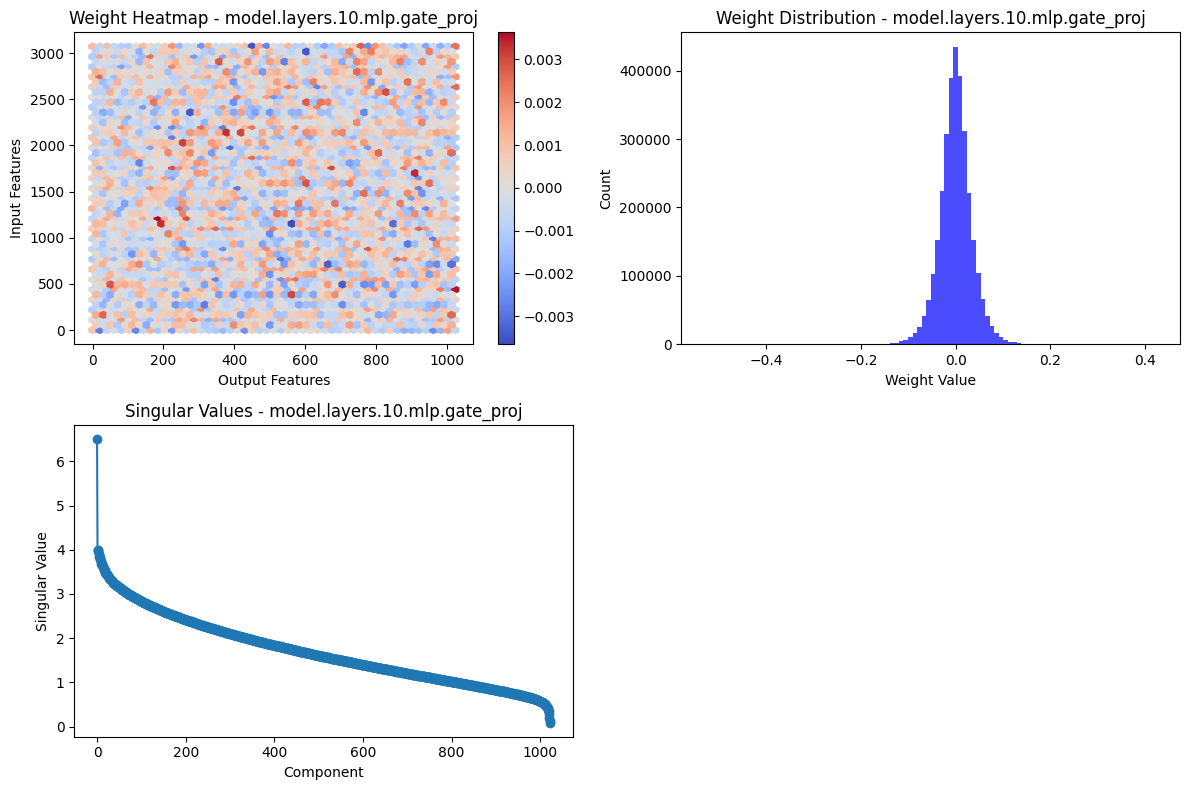


Visualizing layer: model.layers.10.mlp.up_proj
Shape: torch.Size([3072, 1024])


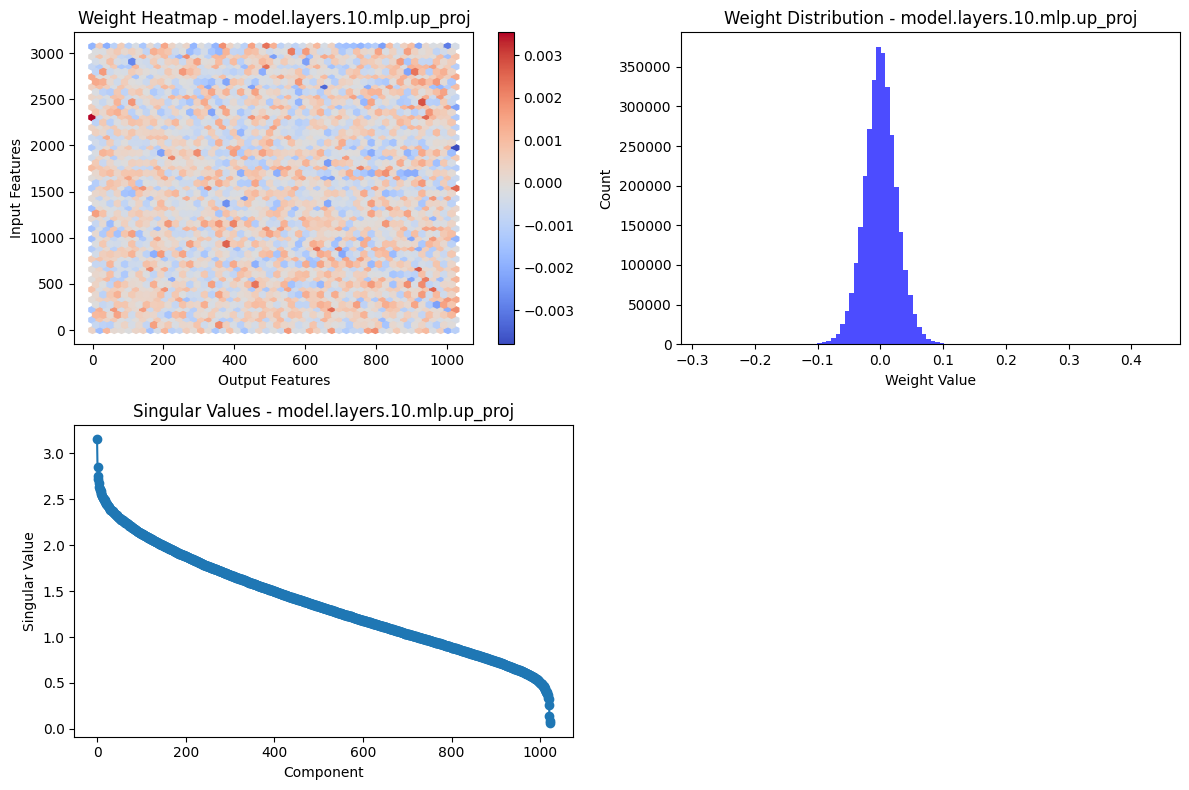


Visualizing layer: model.layers.10.mlp.down_proj
Shape: torch.Size([1024, 3072])


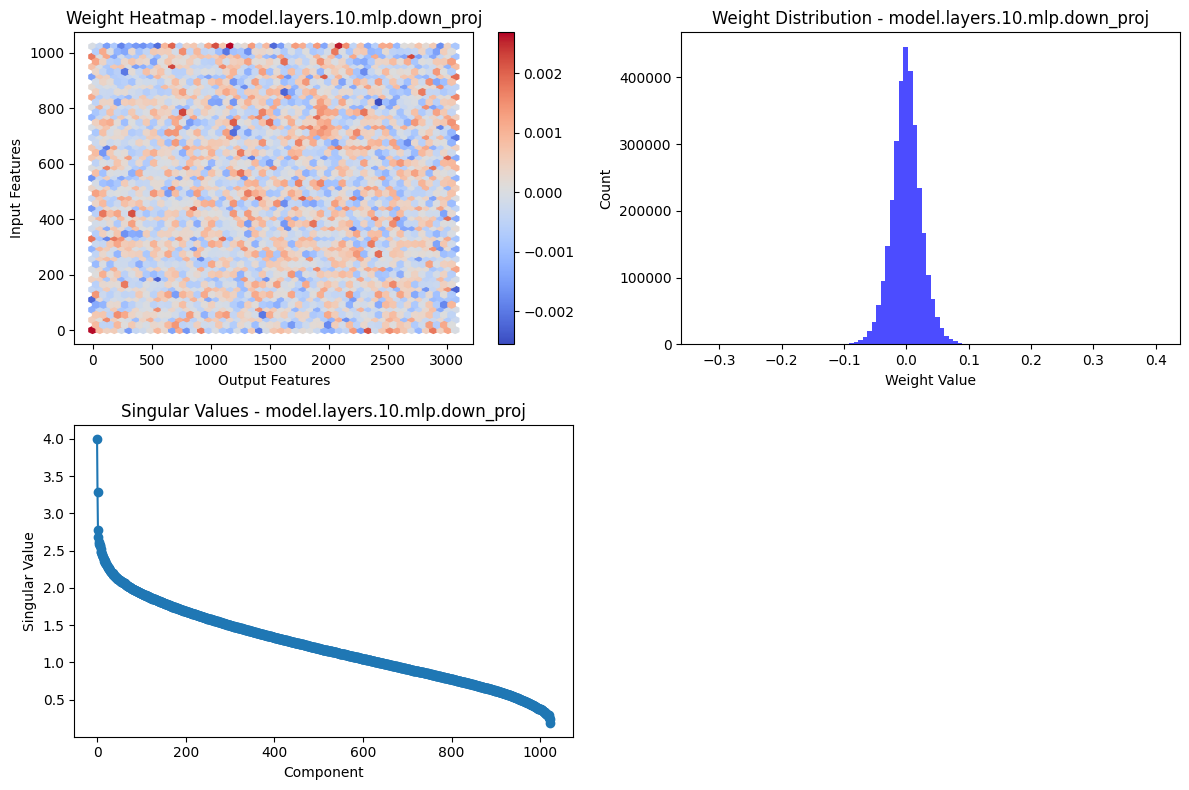


Visualizing layer: model.layers.11.mlp.gate_proj
Shape: torch.Size([3072, 1024])


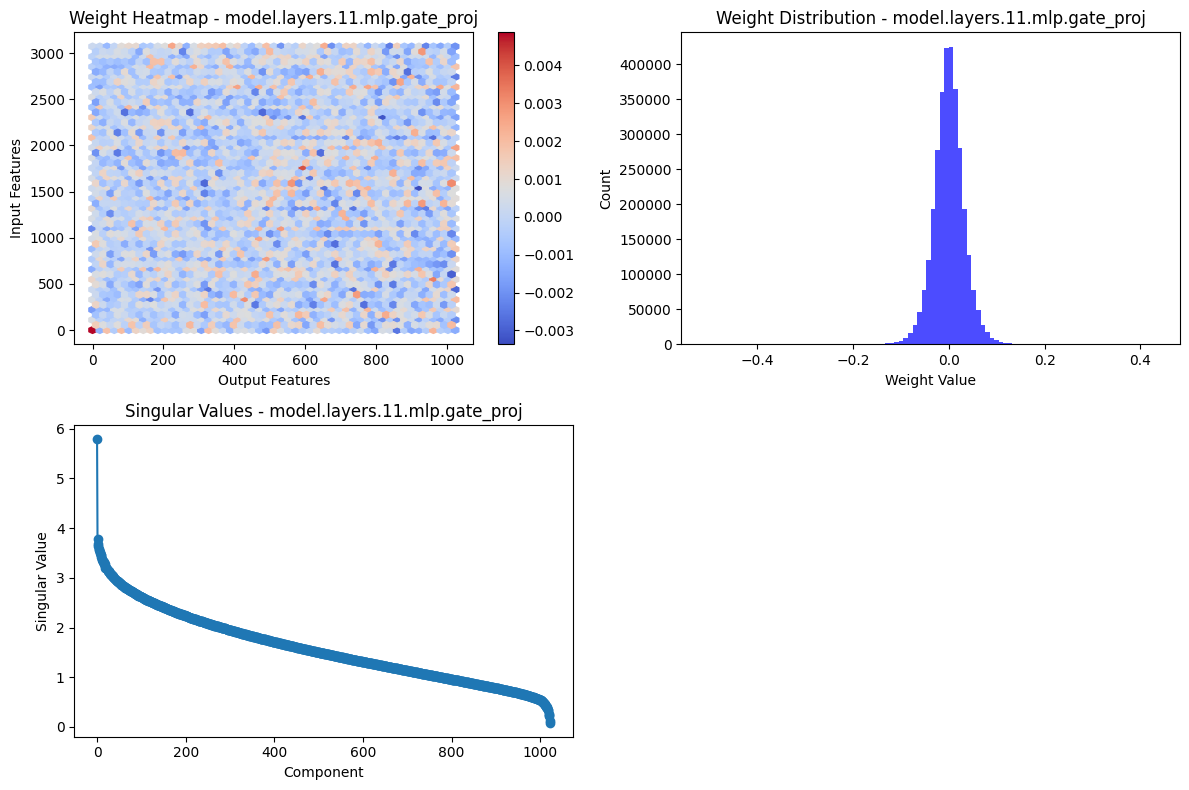


Visualizing layer: model.layers.11.mlp.up_proj
Shape: torch.Size([3072, 1024])


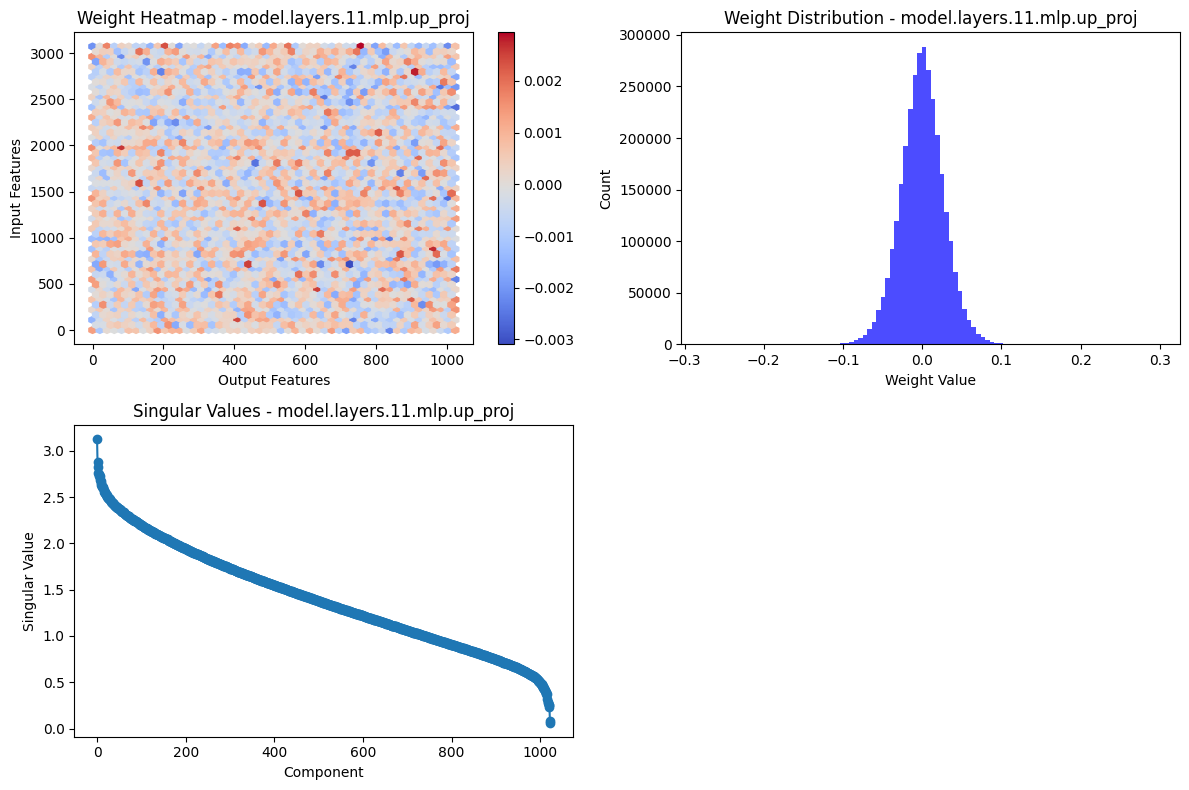

In [8]:
model_name = "Qwen/Qwen3-0.6B-Base"  # Replace with your checkpoint

visualize_qwen_linear_layers(
    model_name=model_name,
    max_layers_to_plot=35
)

- **Why do all of them look like normal distributions**?
It seems because of th type of initialization its done for the weights at the end of the day, the values of the weight don't move that much from the initialization in a way
- Also in majoirty of layers it seems majoirty of layers have weights with very high ranks